In [1]:
import glob
import os
import pickle
import random
import sys

import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [6]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath'
# mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

# Load data

In [7]:
home_dir = "/project/dinner/scguo/kaiB"
base_dir = "/project/dinner/scguo/kaiB/dga/91"

In [8]:
def load_cvs(base_dir, n_s, n_i):
    raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds = [], [], [], [], []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                idx = f"{i:02}_{j:02}_{iso}"
                head = f"{idx}_dga"
                if not os.path.exists(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl"):
                    continue
                raw_feats.extend(
                    np.load(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl", allow_pickle=True)
                )
                fs_qtots.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
                f_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
                p_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
                r_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))
    return raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds

In [9]:
raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds = load_cvs(base_dir, 5, 32)

In [10]:
print(len(raw_feats), raw_feats[0].shape)

640 (39997, 325)


In [11]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

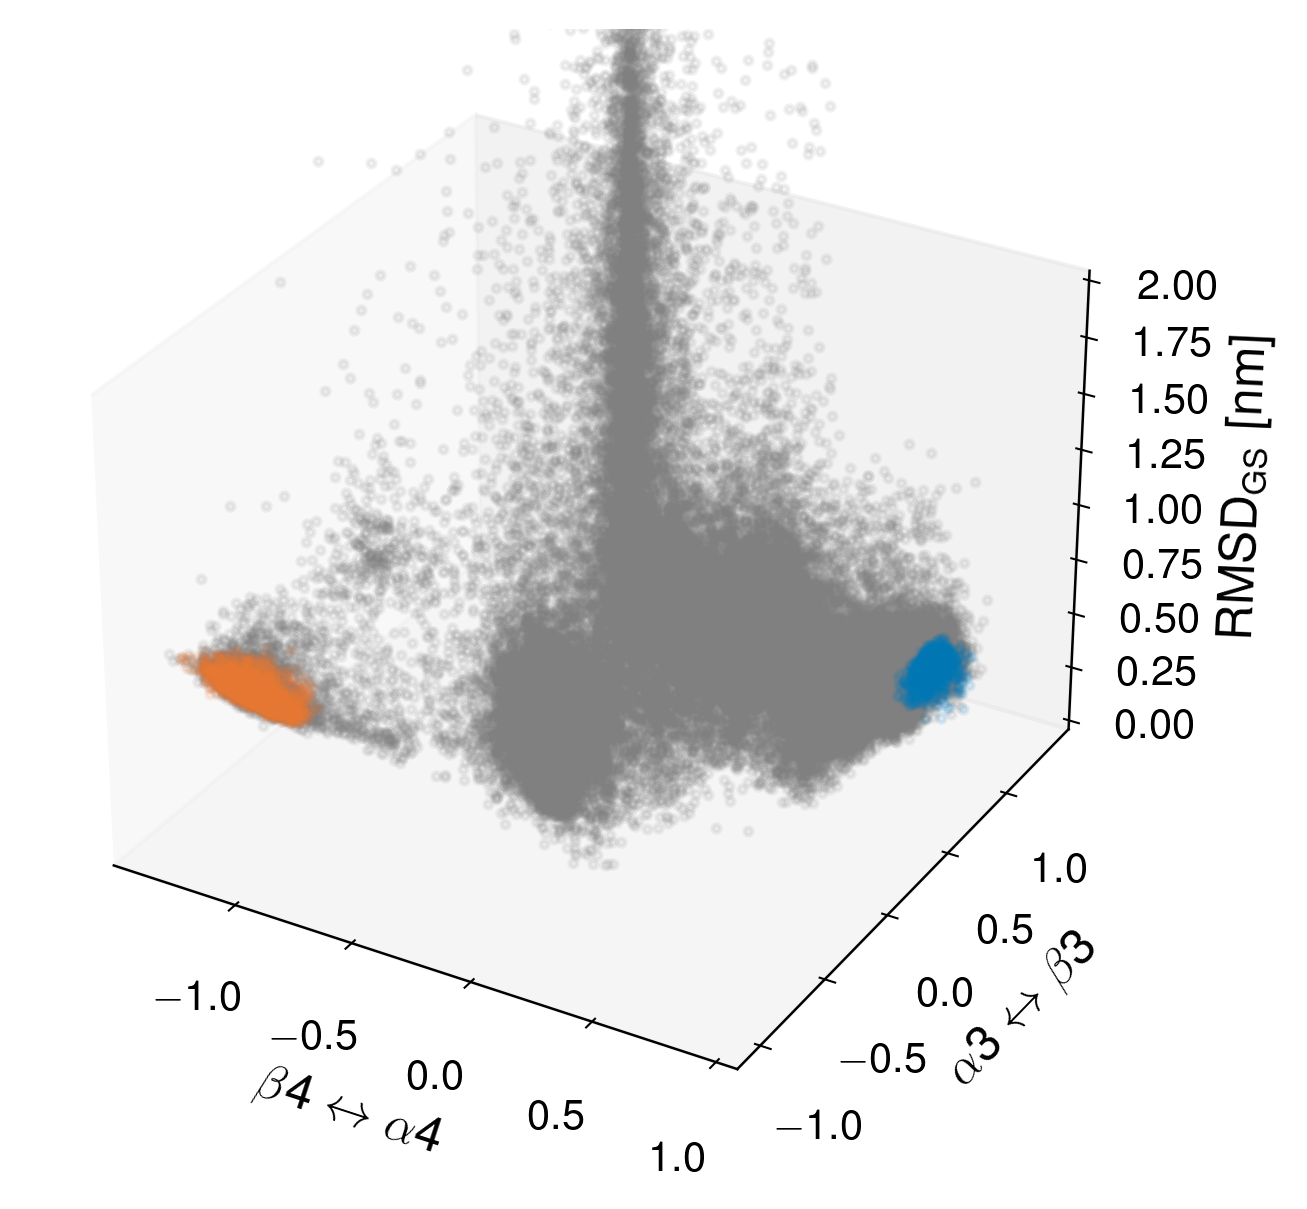

In [12]:
p_rmsd_arr = np.asarray(p_rmsds).ravel()
f_rmsd_arr = np.asarray(f_rmsds).ravel()
in_fs = np.logical_and(
    c_green_arr < -0.78,
    np.logical_and(c_blue_arr < -0.83, np.logical_and(c_orange_arr < -0.75, f_rmsd_arr < 0.35)),
)

in_gs = np.logical_and(
    c_green_arr > 0.67,
    np.logical_and(c_blue_arr > 0.88, np.logical_and(c_orange_arr > 0.75, p_rmsd_arr < 0.45)),
)

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(projection="3d")
ax.plot(c_green_arr[::500], c_blue_arr[::500], p_rmsd_arr[::500], "o", color="gray", alpha=0.1)
ax.plot(
    c_green_arr[in_fs][::500],
    c_blue_arr[in_fs][::500],
    p_rmsd_arr[in_fs][::500],
    "o",
    color="C0",
    alpha=0.1,
)
ax.plot(
    c_green_arr[in_gs][::500],
    c_blue_arr[in_gs][::500],
    p_rmsd_arr[in_gs][::500],
    "o",
    color="C1",
    alpha=0.1,
)
ax.set_zlim([0, 2])
ax.set_xlabel(r"$\beta4\leftrightarrow \alpha4$", fontsize=12)
ax.set_ylabel(r"$\alpha3\leftrightarrow\beta3$", fontsize=12)
ax.set_zlabel(r"RMSD$_{\mathrm{GS}}$ [nm]", fontsize=12)
fig.tight_layout()

## Prolines

In [13]:
def load_omegas(base_dir, n_s, n_i):
    omegas = []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                for k in range(2):
                    idx = f"{i:02}_{j:02}_{iso}"
                    if not os.path.exists(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"):
                        continue
                    omegas.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"))
    return omegas

In [14]:
omegas = load_omegas(base_dir, 5, 32)

In [15]:
n_cis, p63_cis, p70_cis, p71_cis, p72_cis = [], [], [], [], []
for omega in omegas:
    n_cis.append(np.sum((np.abs(omega[:, 3:]) <= (np.pi / 2.0)).astype(int), axis=1))
    p63_cis.append((np.abs(omega[:, 3]) <= (np.pi / 2.0)).astype(int))
    p70_cis.append((np.abs(omega[:, 4]) <= (np.pi / 2.0)).astype(int))
    p71_cis.append((np.abs(omega[:, 5]) <= (np.pi / 2.0)).astype(int))
    p72_cis.append((np.abs(omega[:, 6]) <= (np.pi / 2.0)).astype(int))

# IVAC

In [15]:
import ivac

In [16]:
minlag = 10
maxlag = 1000
livac = ivac.LinearIVAC(minlag, maxlag, nevecs=10)
livac.fit(raw_feats)
ivac_trajs = livac.transform(raw_feats)

In [17]:
# save IVAC object to transform other data
import dill

In [18]:
with open(f"{base_dir}/dga_data/ivac.pkl", mode="wb+") as f:
    dill.dump(livac, f)

In [19]:
np.save(f"{base_dir}/dga_data/ivac_10d_10-1000.npy", ivac_trajs)

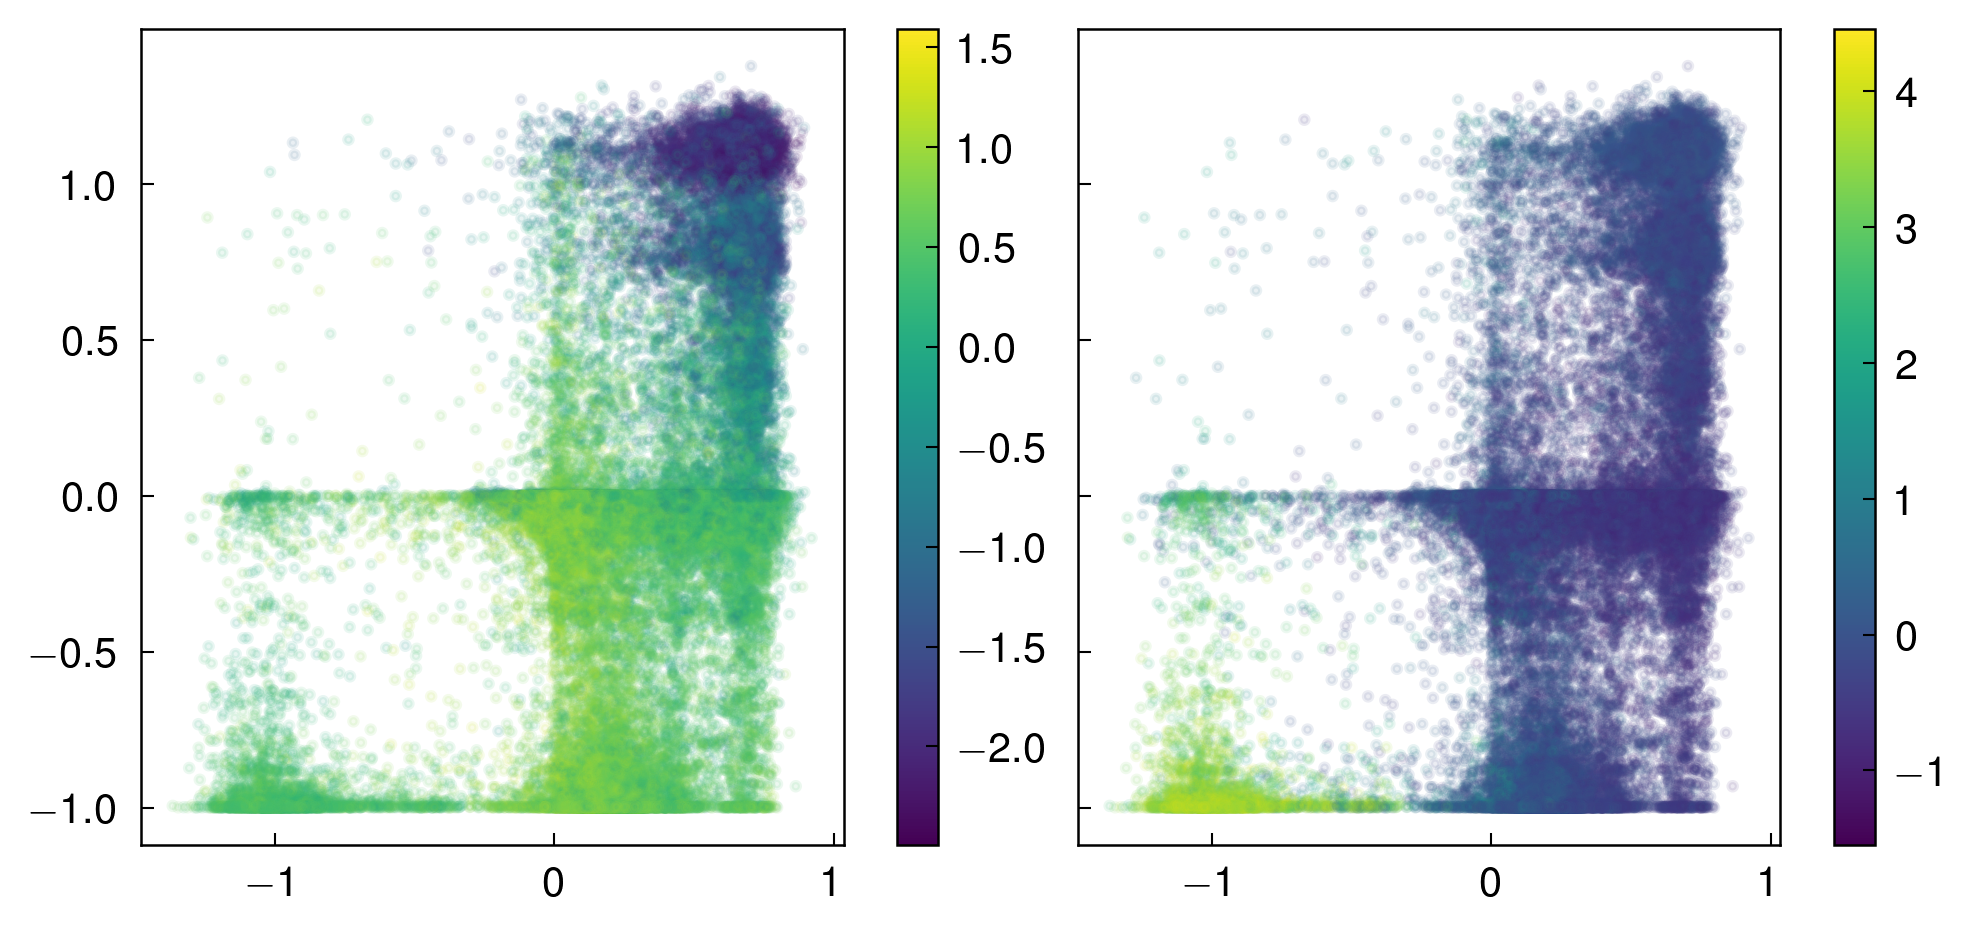

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True, constrained_layout=True)
for i, ax in enumerate(axes):
    sc = ax.scatter(c_green_arr[::500], c_blue_arr[::500], c=np.concatenate(ivac_trajs)[::500, i + 1], alpha=0.1, marker="o")
    cb = plt.colorbar(sc, ax=ax)
    cb.solids.set(alpha=1.)

# $k$-means clustering and basis

In [71]:
k = 300
km = MiniBatchKMeans(k)
km.fit(np.concatenate(ivac_trajs))

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=300)

In [72]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1, n_jobs=-1)
neighbors.fit(centers)

NearestNeighbors(n_jobs=-1, n_neighbors=1)

In [73]:
with open(f"{base_dir}/dga_data/nneighbors.pkl", mode="wb+") as f:
    dill.dump(neighbors, f)

In [74]:
dtraj = neighbors.kneighbors(np.concatenate(ivac_trajs), return_distance=False)

In [16]:
# np.save(f"{base_dir}/dga_data/dtraj_300.npy", dtraj)
dtraj = np.load(f"{base_dir}/dga_data/dtraj_300.npy")

# Indicator basis and guess functions

In [17]:
def make_sparse_basis(dtrajs):
    """Converts a discretized trajectory (e.g. from k-means clustering)
    into a sparse basis of indicator functions.

    Parameters
    ----------
    dtrajs : ndarray
        discretized trajectories

    Return
    ------
    basis : scipy.sparse.csr_matrix
    """
    nclusters = len(np.unique(dtrajs))
    rows, cols = [], []
    for i in range(nclusters):
        pts = np.argwhere(dtrajs == i)
        # indices of which frames are in the cluster i
        rows.append(pts.squeeze())
        # all assigned as 1 in the basis
        cols.append(np.repeat(i, len(pts)))
    rows = np.hstack(rows)
    cols = np.hstack(cols)
    data = np.ones(len(rows), dtype=float)
    basis = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(dtrajs), nclusters))
    return basis

In [18]:
def split_indices(arrays):
    """Gets the indices for np.split from a
    list of arrays.

    Parameters
    ----------
    arrays : ndarray or list/tuple of ndarray
        Arrays from which to get indices

    Returns
    -------
    traj_inds : list of int
        Frame separators to use in np.split
    """
    traj_lens = [len(traj) for traj in arrays]
    traj_inds = []
    subtot = 0
    for length in traj_lens[:-1]:
        subtot += length
        traj_inds.append(subtot)
    return traj_inds

In [19]:
# split into lists of arrays
basis_arr = make_sparse_basis(np.squeeze(dtraj))[:, :-1]
basis_d_arr = basis_arr.copy()
basis_d_arr[in_fs] = 0
basis_d_arr[in_gs] = 0

traj_lens = [len(traj) for traj in raw_feats]
basis, basis_d = [], []
curr = 0
for t_len in traj_lens:
    basis.append(basis_arr[curr : curr + t_len])
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

traj_inds = split_indices(raw_feats)
guess_fs = np.split(in_fs.astype(float), traj_inds)
guess_gs = np.split(in_gs.astype(float), traj_inds)

print(len(basis), basis[0].shape)

/home/scguo/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


640 (39997, 299)


# Weights, PMF, eq averages

In [20]:
# saved every 50 time steps
lags = np.array([100, 200, 500, 1000, 2000, 5000], dtype=int)
lagtimes = lags * 50

In [80]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basis, lag))

In [22]:
# np.save(f"{base_dir}/dga_data/weights.npy", weights, allow_pickle=True)
weights = np.load(f"{base_dir}/dga_data/weights.npy")

## PMFs

/scratch/local/jobs/6541398/ipykernel_1526789/582228347.py:17: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/6541398/ipykernel_1526789/582228347.py:18: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


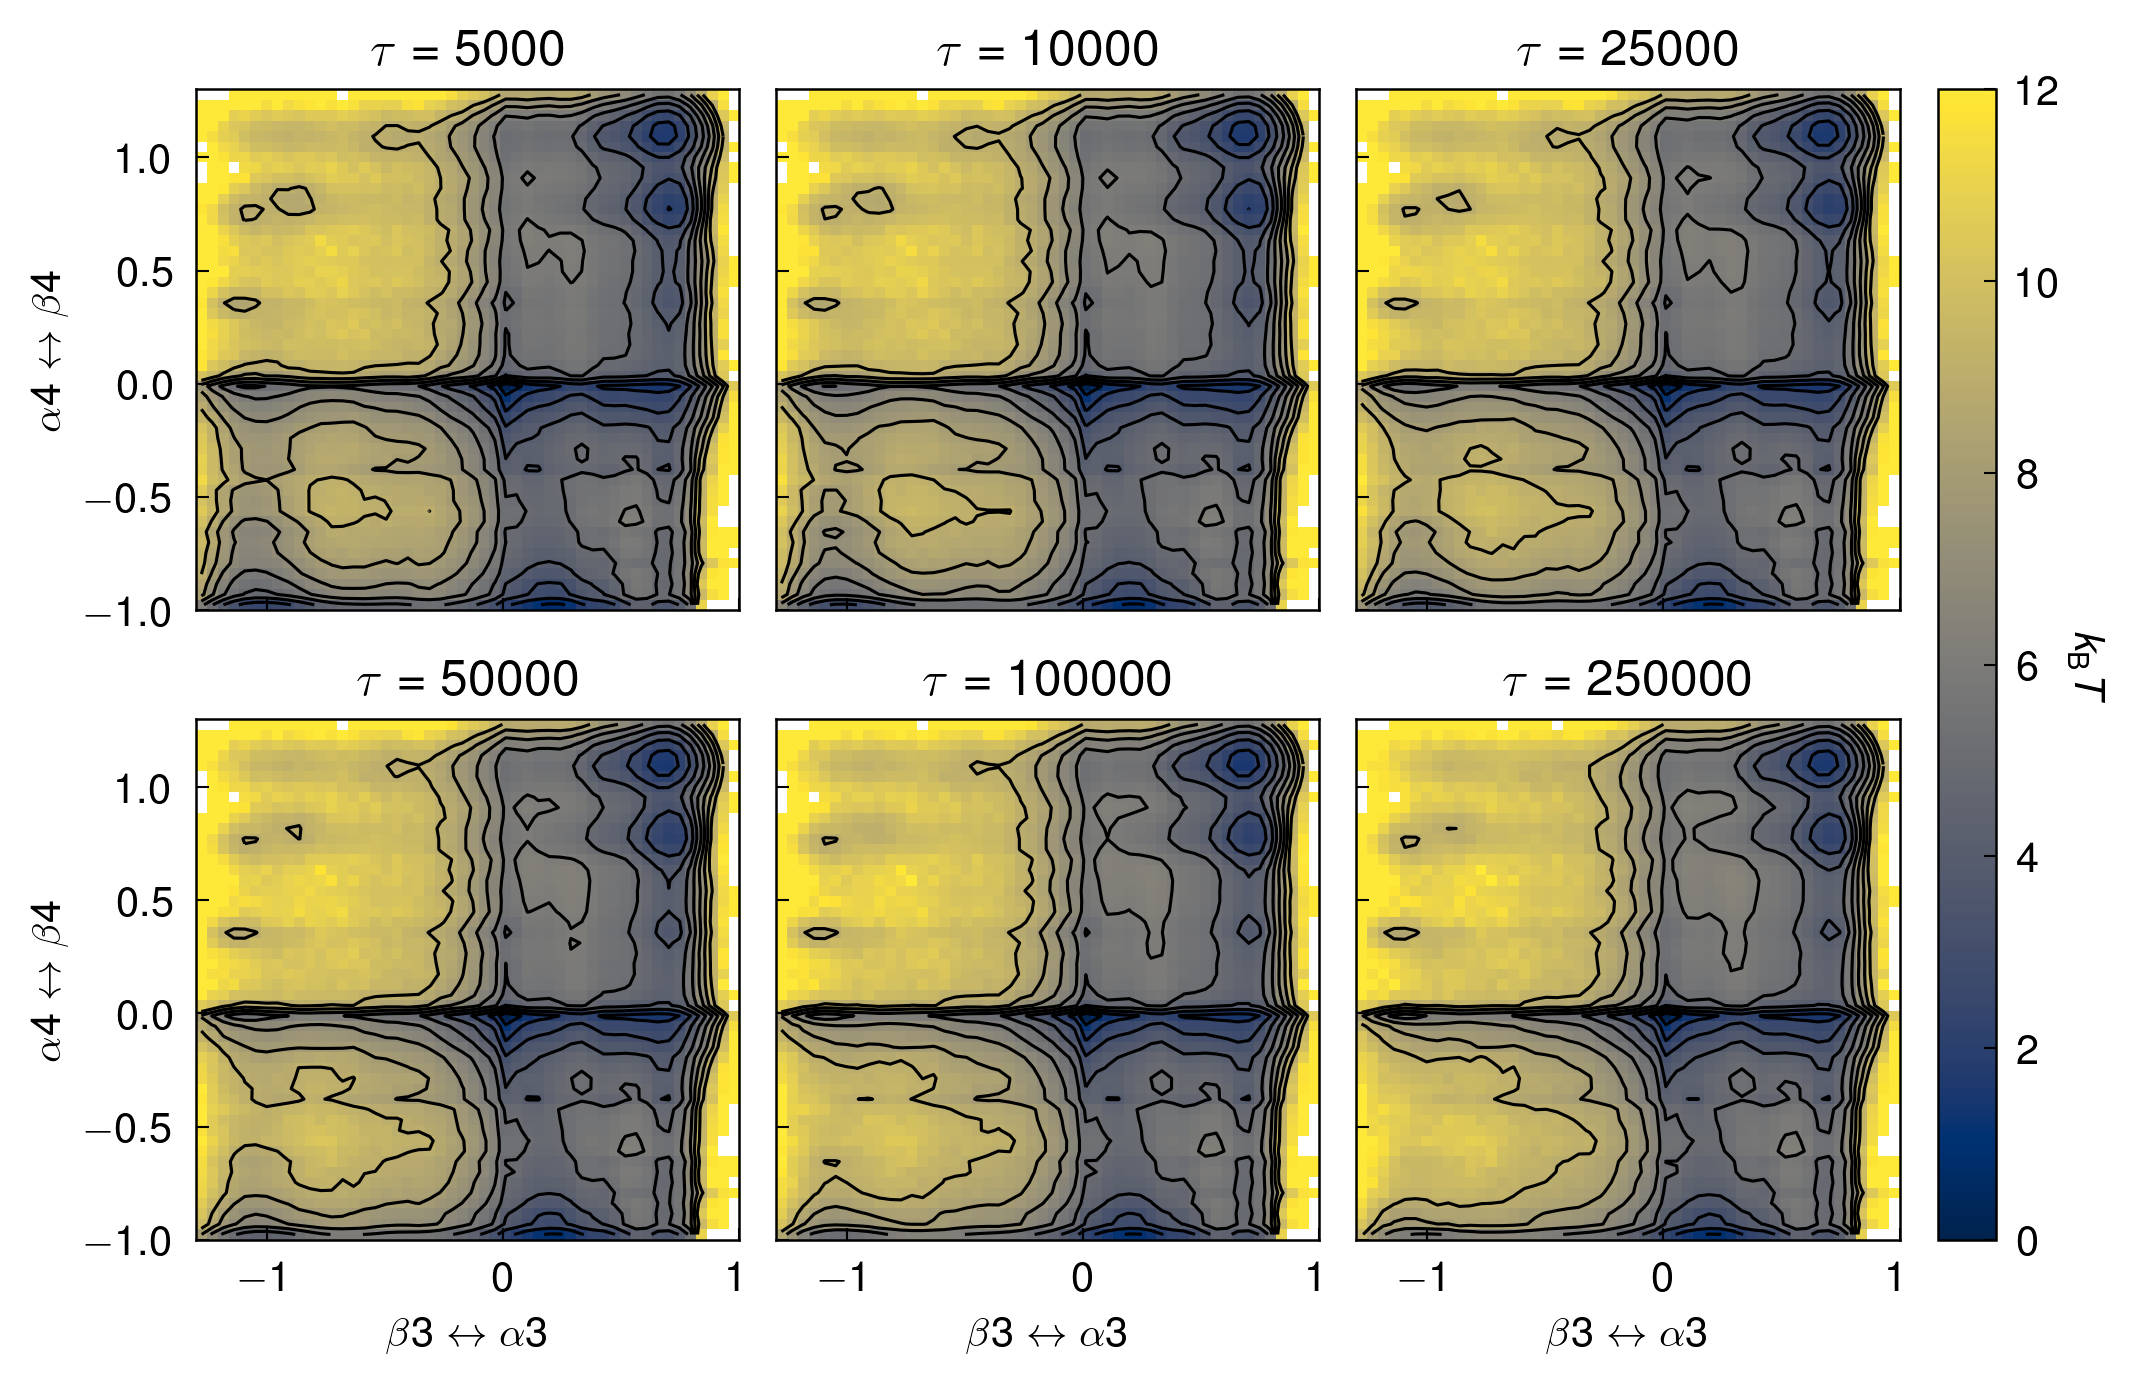

In [82]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(10)

for ax, lag, lagtime, w in zip(axes.flat, lags, lagtimes, weights):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[lag:] for t in c_green]
    cv2_delay = [t[lag:] for t in c_blue]
    hist = extq.projection.density2d(cv1_delay, cv2_delay, w_delay, xe, ye)
    offset = np.min(-np.log(hist))
    pmf = -np.log(hist) - offset
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="cividis", vmax=12)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.set_title(f"$\\tau$ = {lagtime}")
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[:, -1])
cb.set_label(r"$k_{\mathrm{B}}T$", rotation=-90, labelpad=10)

### figure

/scratch/local/jobs/6541398/ipykernel_1526789/2889820717.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/6541398/ipykernel_1526789/2889820717.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


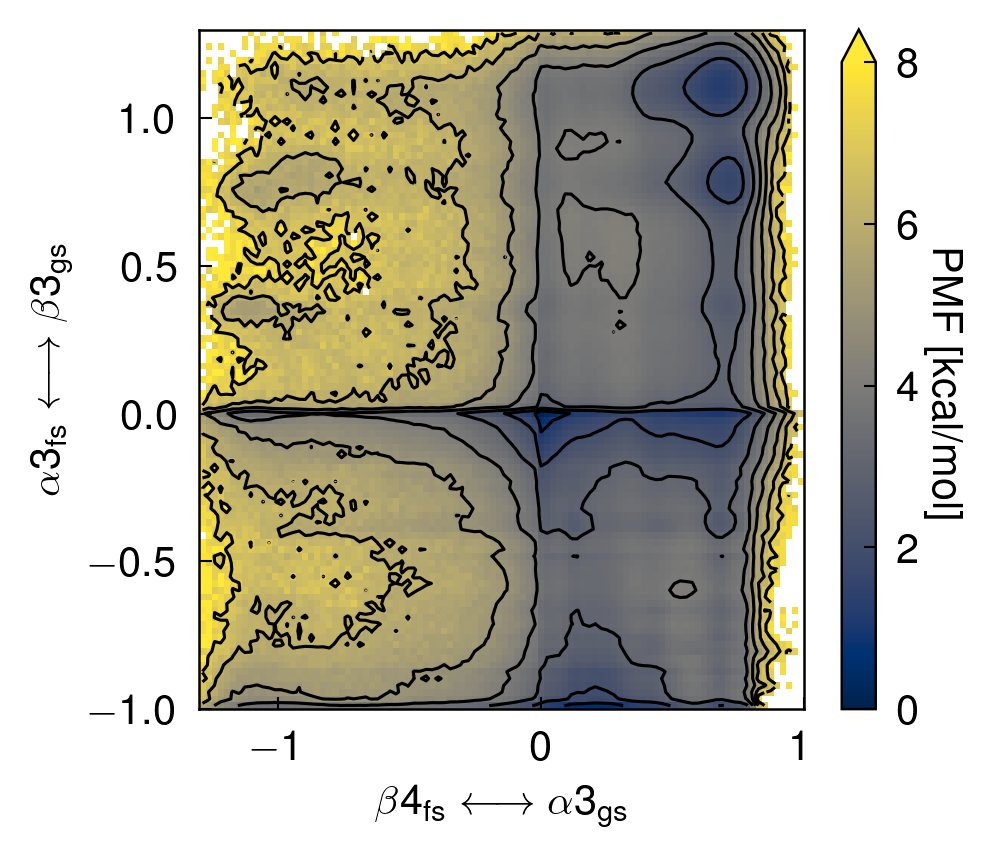

In [83]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.25, 3), dpi=300)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(8)

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
hist = extq.projection.density2d(cv1_delay, cv2_delay, w_delay, xe, ye)
offset = np.min(-np.log(hist))
pmf = -np.log(hist) - offset
pc = ax.pcolormesh(xc, yc, pmf.T * 0.593, cmap="cividis", vmax=8)
ax.contour(xc, yc, pmf.T * 0.593, colors="black", levels=clines)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta3_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
# ax.set_title(f"$\\tau$ = {lagtime}")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax, extend='max')
cb.set_label("PMF [kcal/mol]", rotation=-90, labelpad=10)

## Eq. averages

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


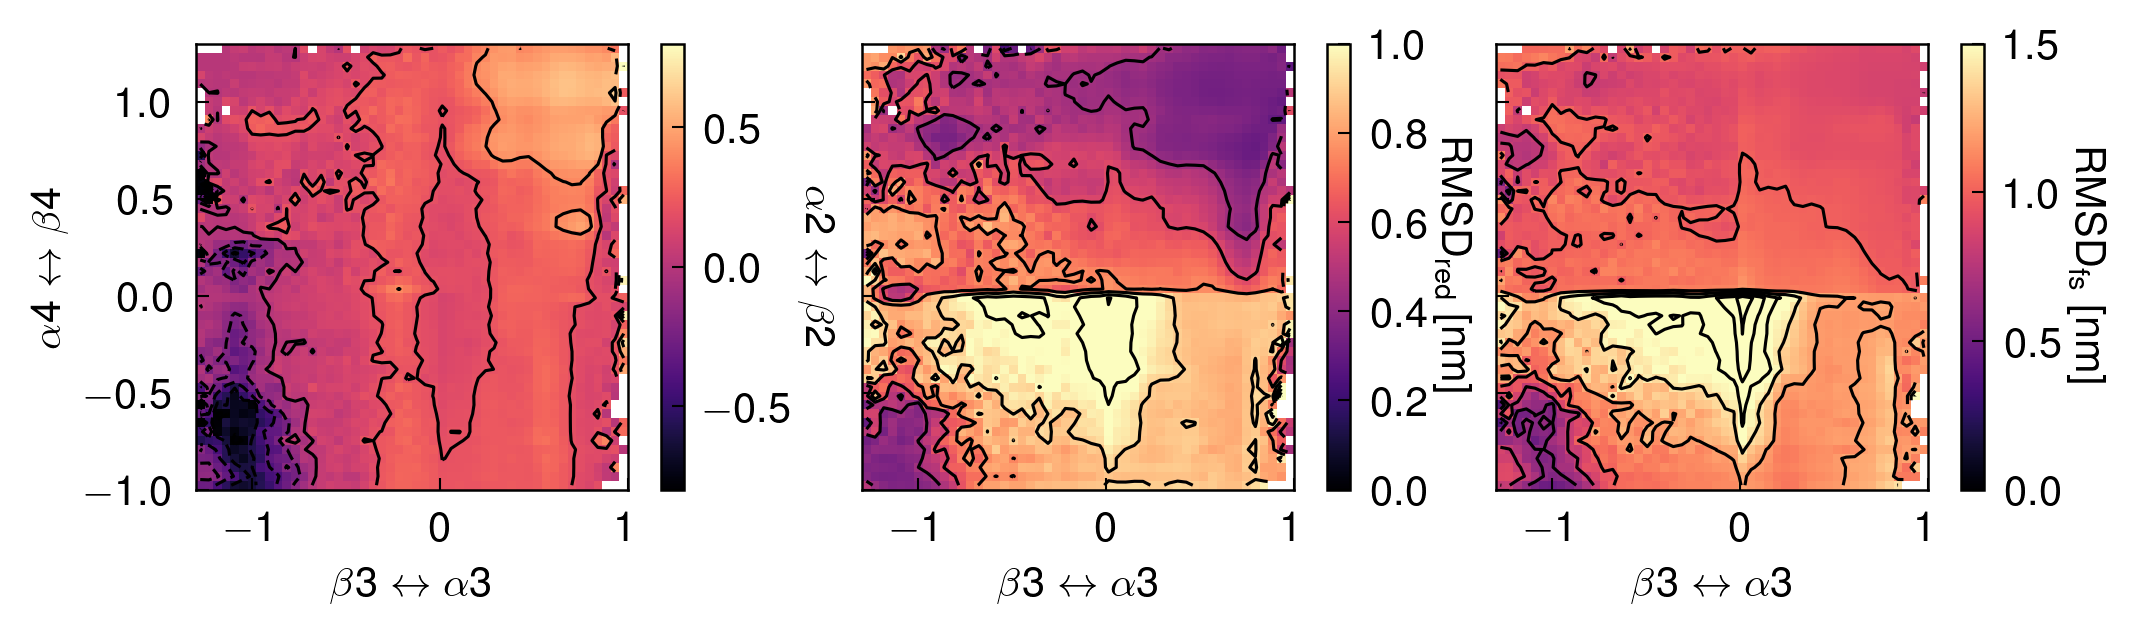

In [84]:
# plot averages of different cvs
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

cvs = [c_orange, r_rmsds, f_rmsds]
labels = [r"$\alpha2\leftrightarrow\beta2$", r"RMSD$_{\mathrm{red}}$ [nm]", r"RMSD$_{\mathrm{fs}}$ [nm]"]
ranges = [(-0.8, 0.8), (0, 1.0), (0, 1.5)]

for ax, cv, label, (vmin, vmax) in zip(axes, cvs, labels, ranges):
    w_delay = [t[:-lag] for t in weights[-1]]
    cv1_delay = [t[lag:] for t in c_green]
    cv2_delay = [t[lag:] for t in c_blue]
    func_delay = [t[lag:] for t in cv]
    hist = extq.projection.average2d(cv1_delay, cv2_delay, func_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="magma", vmin=vmin, vmax=vmax)
    ax.contour(xc, yc, hist.T, colors="black", levels=10)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.label_outer()
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label(label, rotation=-90, labelpad=10)

## Prolines

In [52]:
# % cis in fs/gs
for p, num in zip([p63_cis, p70_cis, p71_cis, p72_cis], [63, 70, 71, 72]):
    N_fs = np.count_nonzero(in_fs)
    N_gs = np.count_nonzero(in_gs)
    print(f"P{num}: fs {np.count_nonzero(np.concatenate(p)[in_fs]) / N_fs * 100:.1f}% cis")
    print(f"P{num}: gs {np.count_nonzero(np.concatenate(p)[in_gs]) / N_gs * 100:.1f}% cis")

P63: fs 18.8% cis
P63: gs 0.0% cis
P70: fs 26.2% cis
P70: gs 0.0% cis
P71: fs 43.4% cis
P71: gs 0.0% cis
P72: fs 3.4% cis
P72: gs 0.2% cis


/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


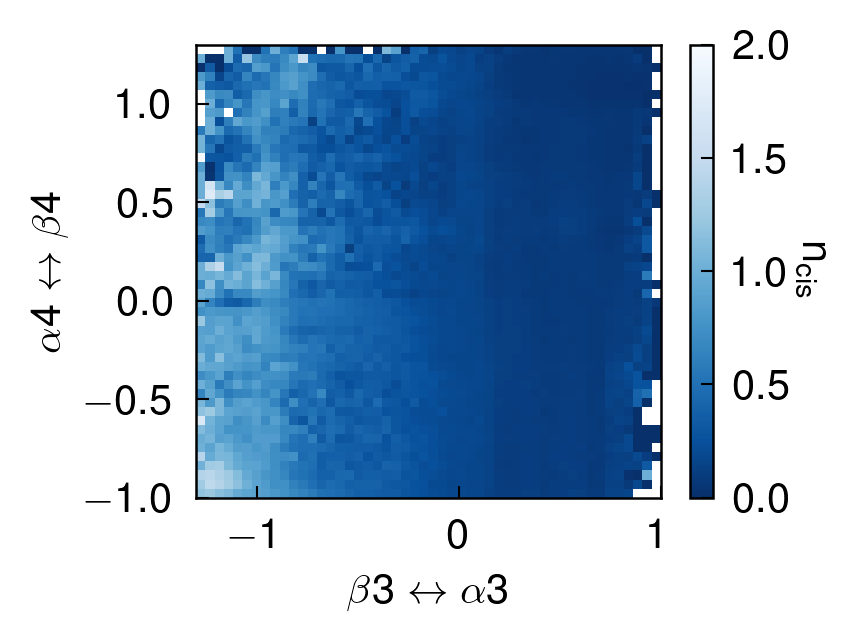

In [36]:
# plot averages of different cvs
fig = plt.figure(figsize=(2.5, 2), dpi=300)
ax = plt.gca()

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
func_delay = [t[lag:] for t in n_cis]
hist = extq.projection.average2d(cv1_delay, cv2_delay, func_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="Blues_r", vmax=2)
# ax.contour(xc, yc, hist.T, colors="black", levels=10)
ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"n$_{\mathrm{cis}}$", rotation=-90, labelpad=10)

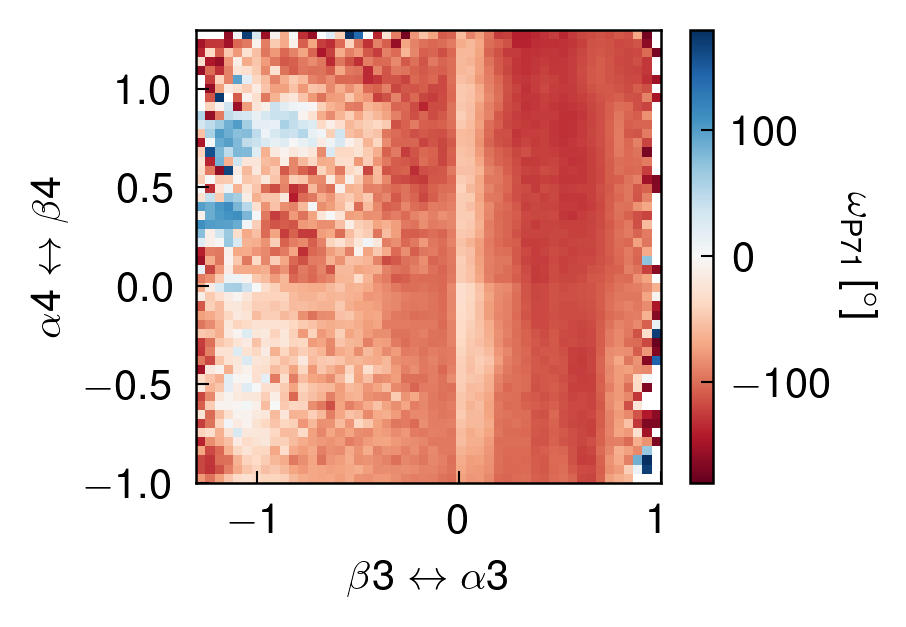

In [53]:
# plot averages of different cvs
fig = plt.figure(figsize=(2.5, 2), dpi=300)
ax = plt.gca()

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
func_delay = [np.degrees(t[lag:, 5]) for t in omegas]
hist = extq.projection.average2d(cv1_delay, cv2_delay, func_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu", vmin=-180, vmax=180)
# ax.contour(xc, yc, hist.T, colors="black", levels=10)
ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$\omega_{\mathrm{P71}}\,[^\circ]$", rotation=-90, labelpad=10)

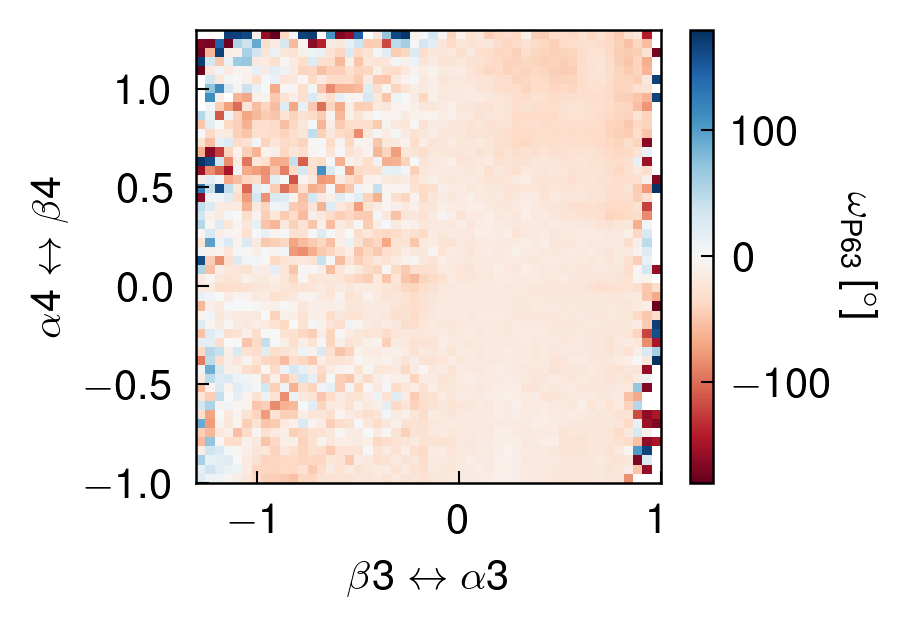

In [54]:
# plot averages of different cvs
fig = plt.figure(figsize=(2.5, 2), dpi=300)
ax = plt.gca()

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
func_delay = [np.degrees(t[lag:, 3]) for t in omegas]
hist = extq.projection.average2d(cv1_delay, cv2_delay, func_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu", vmin=-180, vmax=180)
# ax.contour(xc, yc, hist.T, colors="black", levels=10)
ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$\omega_{\mathrm{P63}}\,[^\circ]$", rotation=-90, labelpad=10)

# Committors

In [85]:
in_domain = ~(in_fs | in_gs)
in_d = np.split(in_domain, traj_inds)

In [86]:
qp_fs2gs, qm_fs2gs, qp_gs2fs, qm_gs2fs = [], [], [], []
coeffs = []
for lag, w in zip(lags, weights):
    print(f"Lag {lag}")
    coef = extq.memory.forward_committor(basis_d, w, in_d, guess_gs, lag, mem=0, output="coef")
    coeffs.append(coef)
    qp_fs2gs.append([x @ coef[:, 0] + g for (x, g) in zip(basis_d, guess_gs)])
    qm_fs2gs.append(extq.dga.backward_committor(basis_d, w, in_d, guess_fs, lag))
    qp_gs2fs.append(extq.dga.forward_committor(basis_d, w, in_d, guess_fs, lag))
    qm_gs2fs.append(extq.dga.backward_committor(basis_d, w, in_d, guess_gs, lag))

Lag 100
Lag 200
Lag 500
Lag 1000
Lag 2000
Lag 5000


In [87]:
np.save(f"{base_dir}/dga_data/qp_fs2gs.npy", qp_fs2gs)
np.save(f"{base_dir}/dga_data/qp_gs2fs.npy", qp_gs2fs)
np.save(f"{base_dir}/dga_data/qm_fs2gs.npy", qm_fs2gs)
np.save(f"{base_dir}/dga_data/qm_gs2fs.npy", qm_gs2fs)
np.save(f"{base_dir}/dga_data/qp_fs2gs_coeffs.npy", coeffs)

In [34]:
def adjust_forward_committor(forward_q, in_domain, lag):
    result_qp = []
    for qp, d in zip(forward_q, in_domain):
        n = len(d)
        assert len(qp) == n
        tp = extq.stop.forward_stop(d)
        iy = np.minimum(np.arange(lag, n), tp[:-lag])
        result_qp.append(qp[iy])
    return result_qp

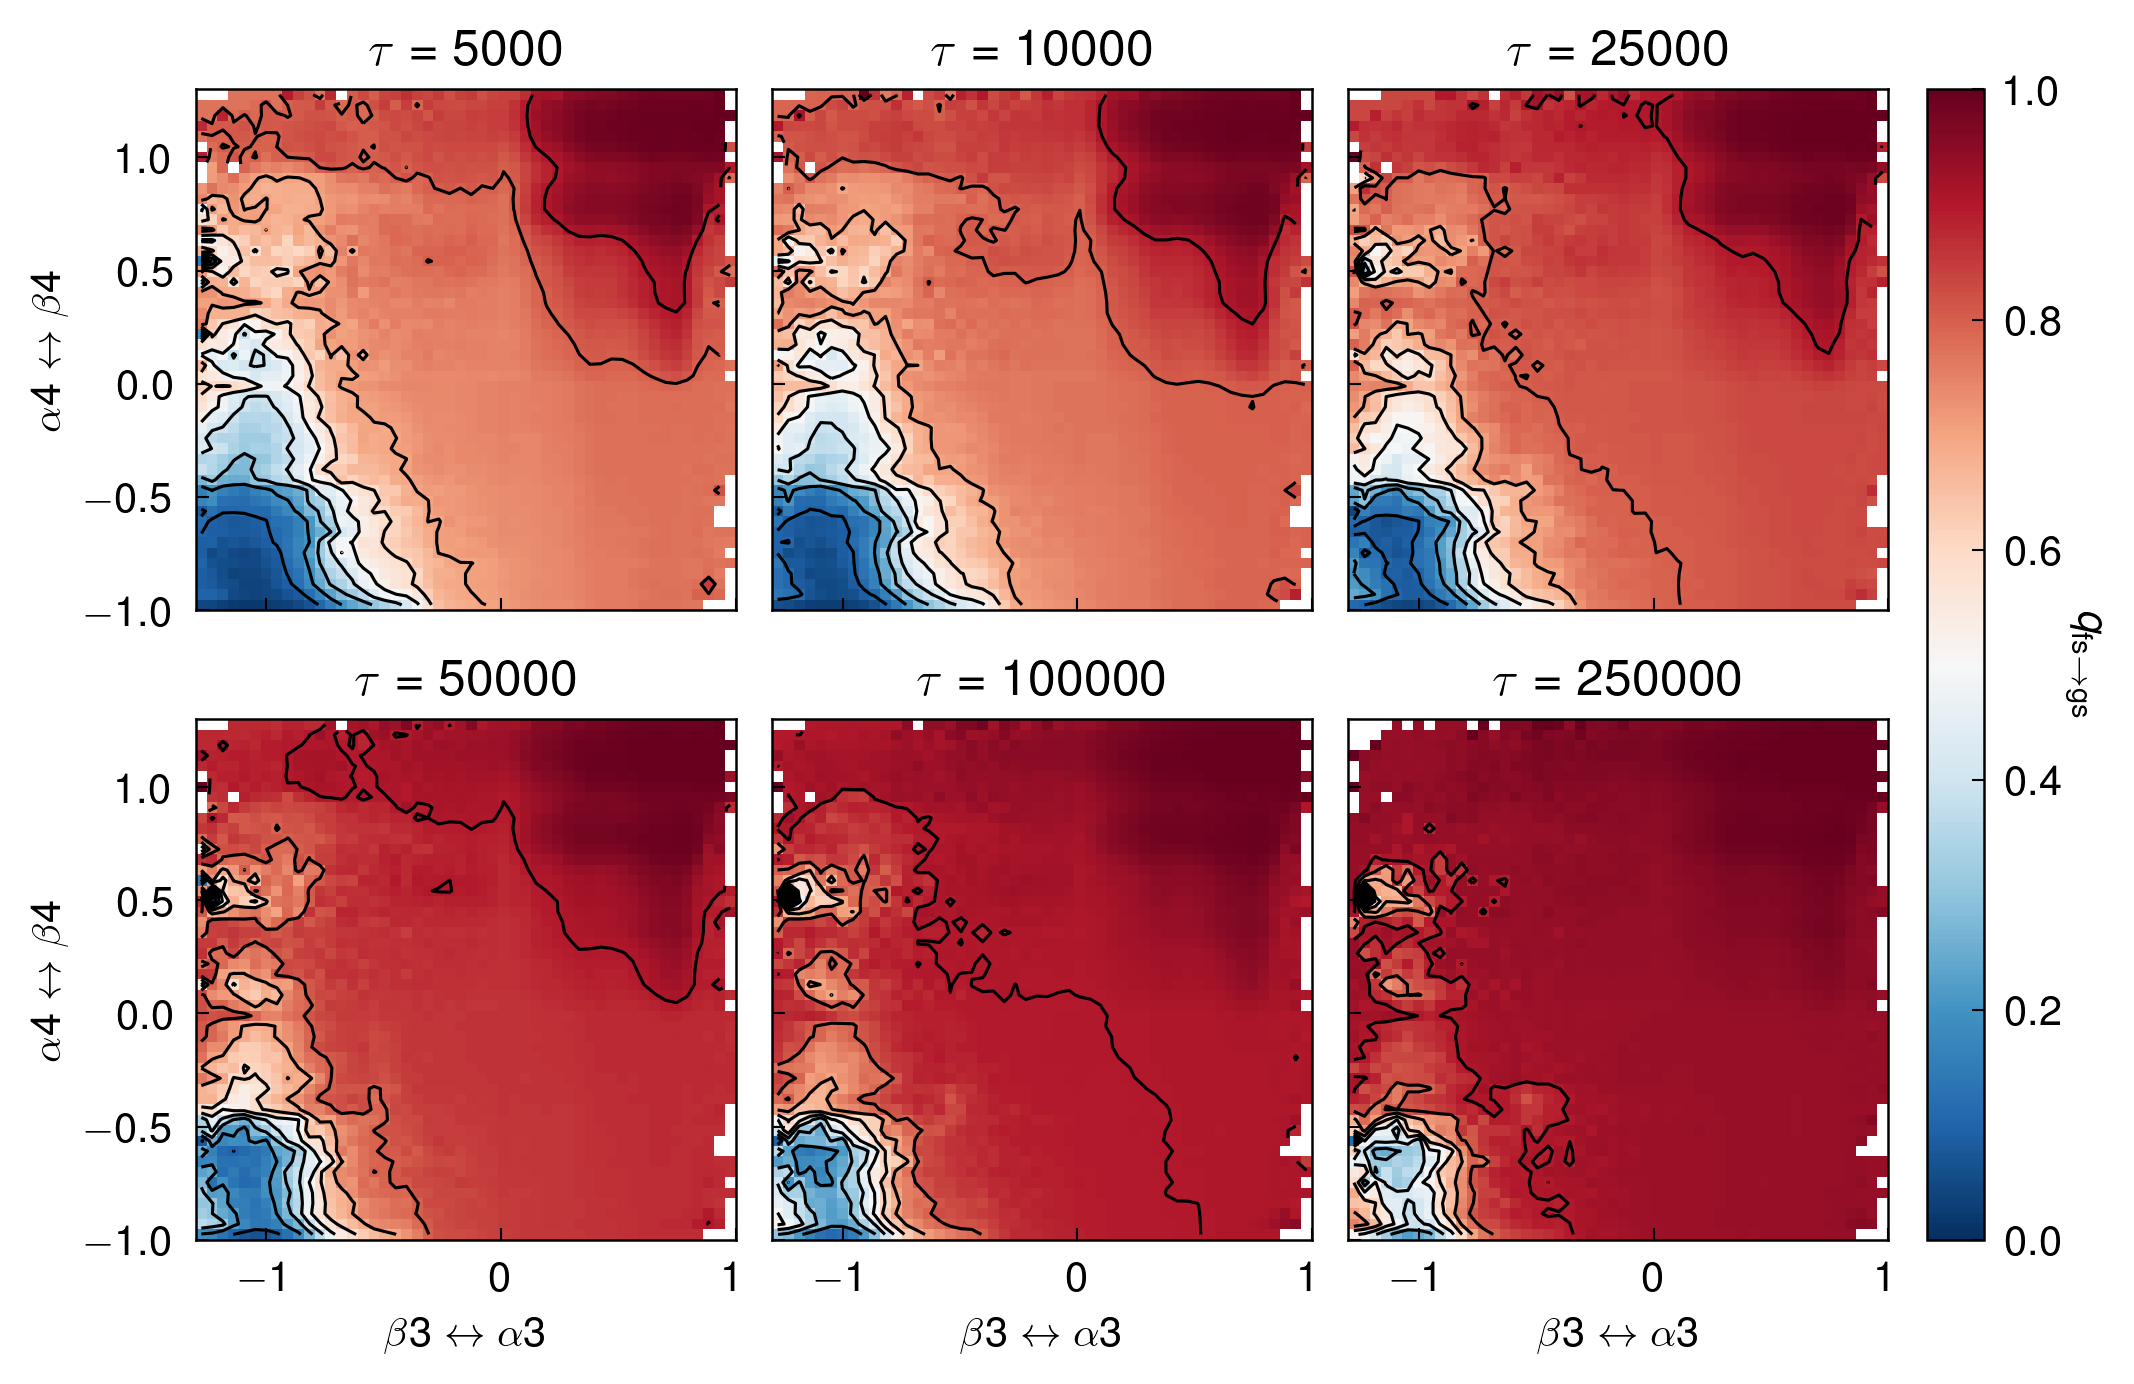

In [92]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.linspace(0, 1, 11)

for ax, lag, lagtime, w, q in zip(axes.flat, lags, lagtimes, weights, qp_fs2gs):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[:-lag] for t in c_green]
    cv2_delay = [t[:-lag] for t in c_blue]
    qp_delay = adjust_forward_committor(q, in_d, lag)
    hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu_r", vmin=0, vmax=1)
    ax.contour(xc, yc, hist.T, colors="black", levels=clines)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.set_title(f"$\\tau$ = {lagtime}")
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[:, -1])
cb.set_label(r"$q_{\mathrm{fs}\rightarrow\mathrm{gs}}$", rotation=-90, labelpad=10)

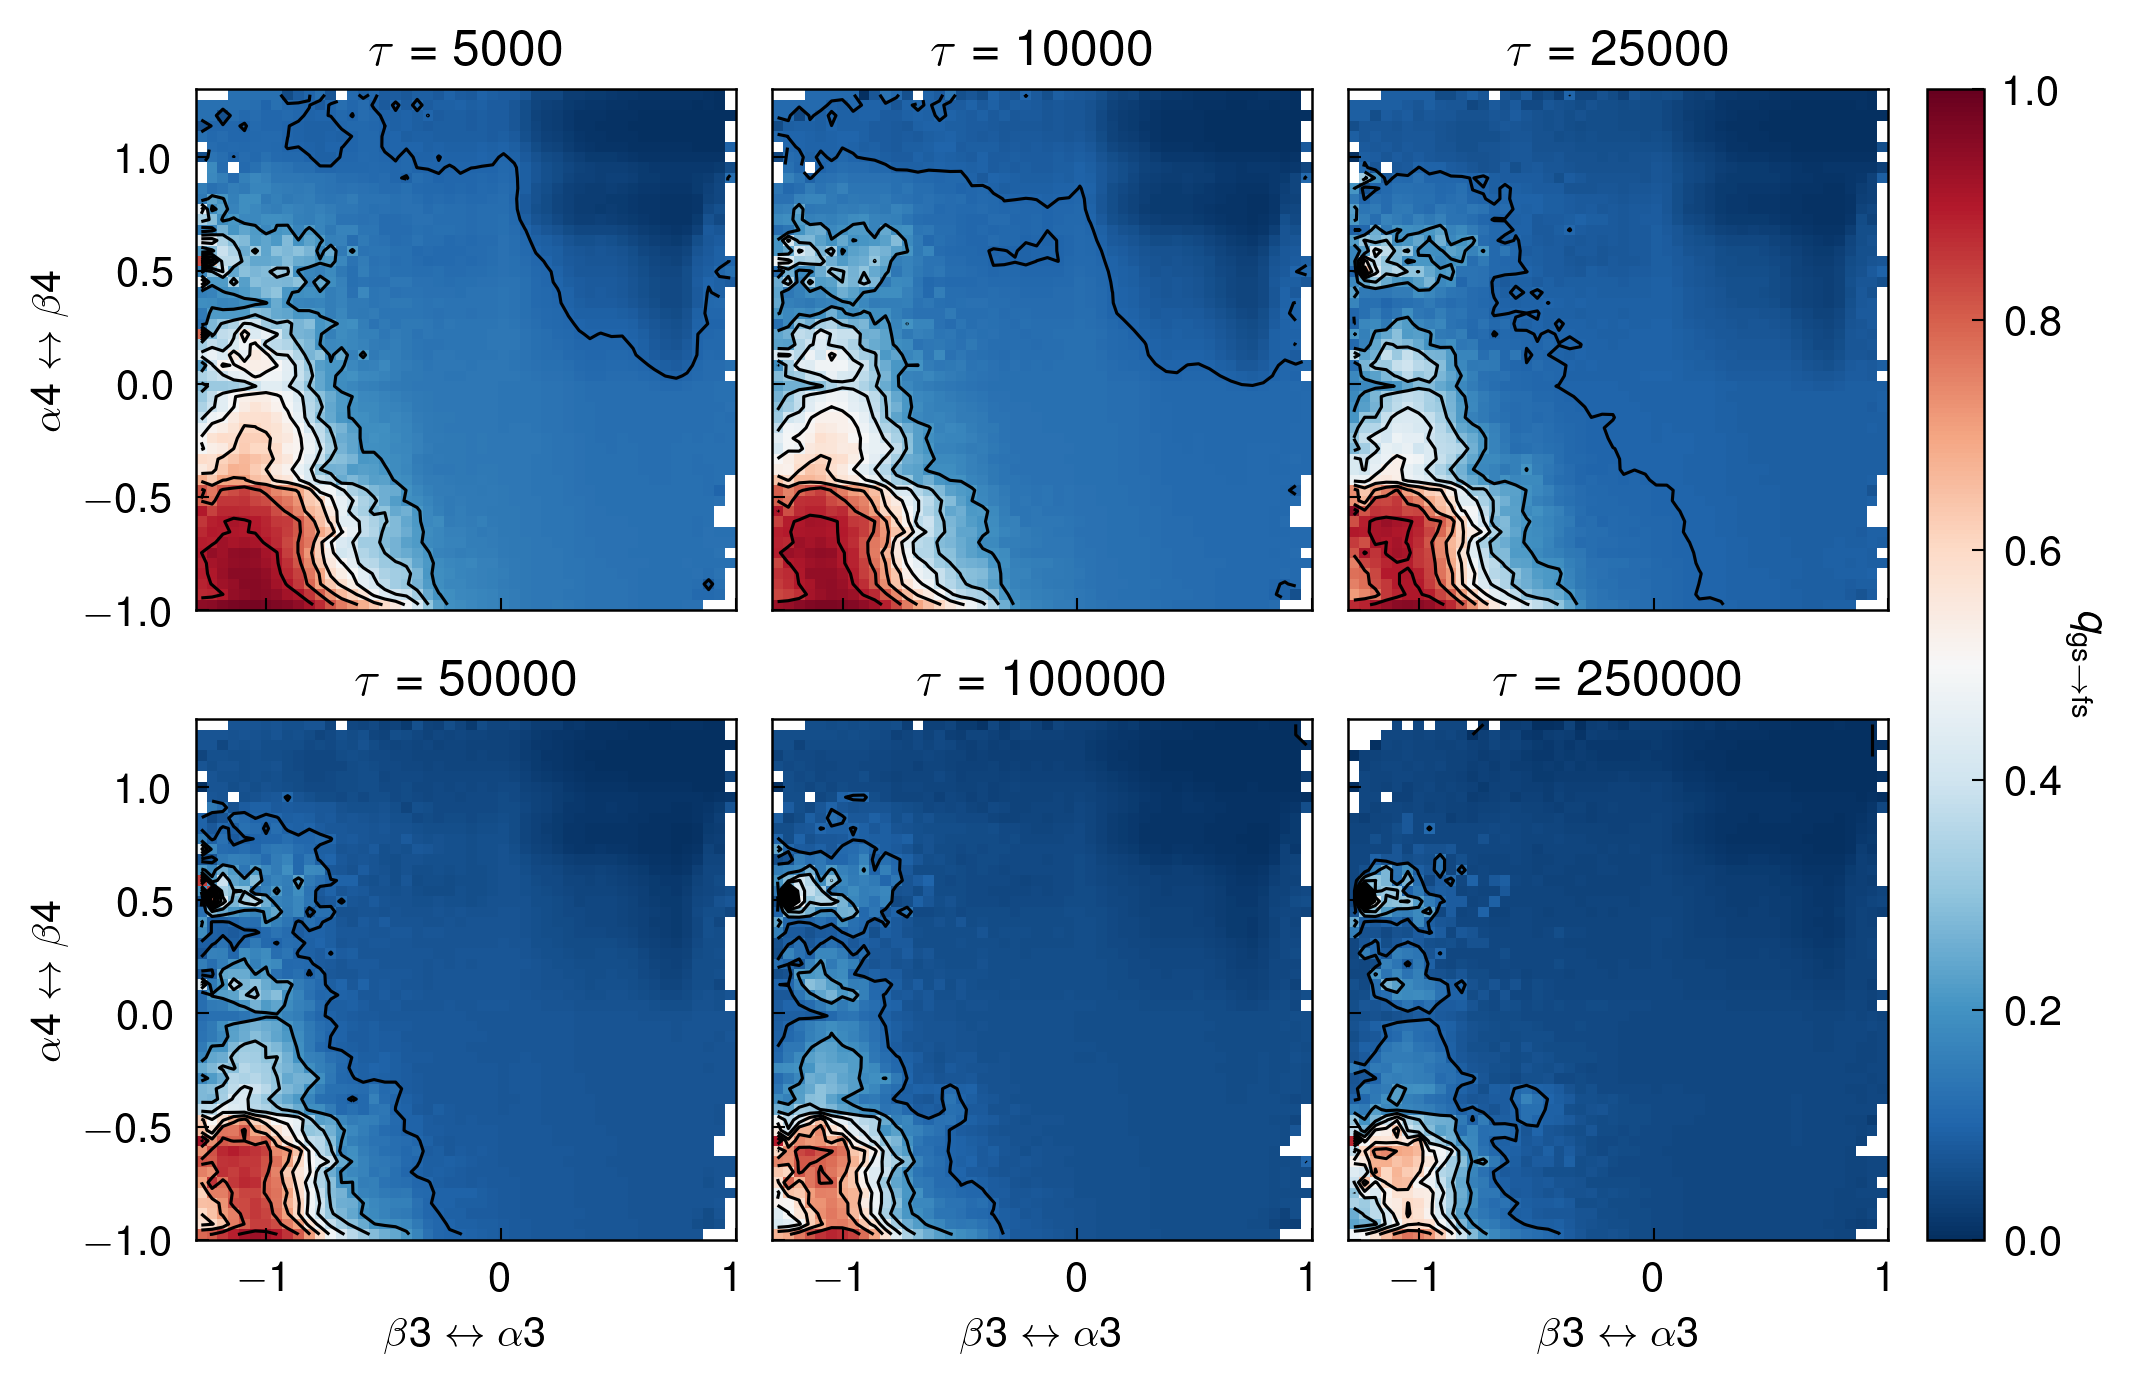

In [93]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.linspace(0, 1, 11)

for ax, lag, lagtime, w, q in zip(axes.flat, lags, lagtimes, weights, qp_gs2fs):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[:-lag] for t in c_green]
    cv2_delay = [t[:-lag] for t in c_blue]
    qp_delay = adjust_forward_committor(q, in_d, lag)
    hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu_r", vmin=0, vmax=1)
    ax.contour(xc, yc, hist.T, colors="black", levels=clines)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.set_title(f"$\\tau$ = {lagtime}")
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[:, -1])
cb.set_label(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

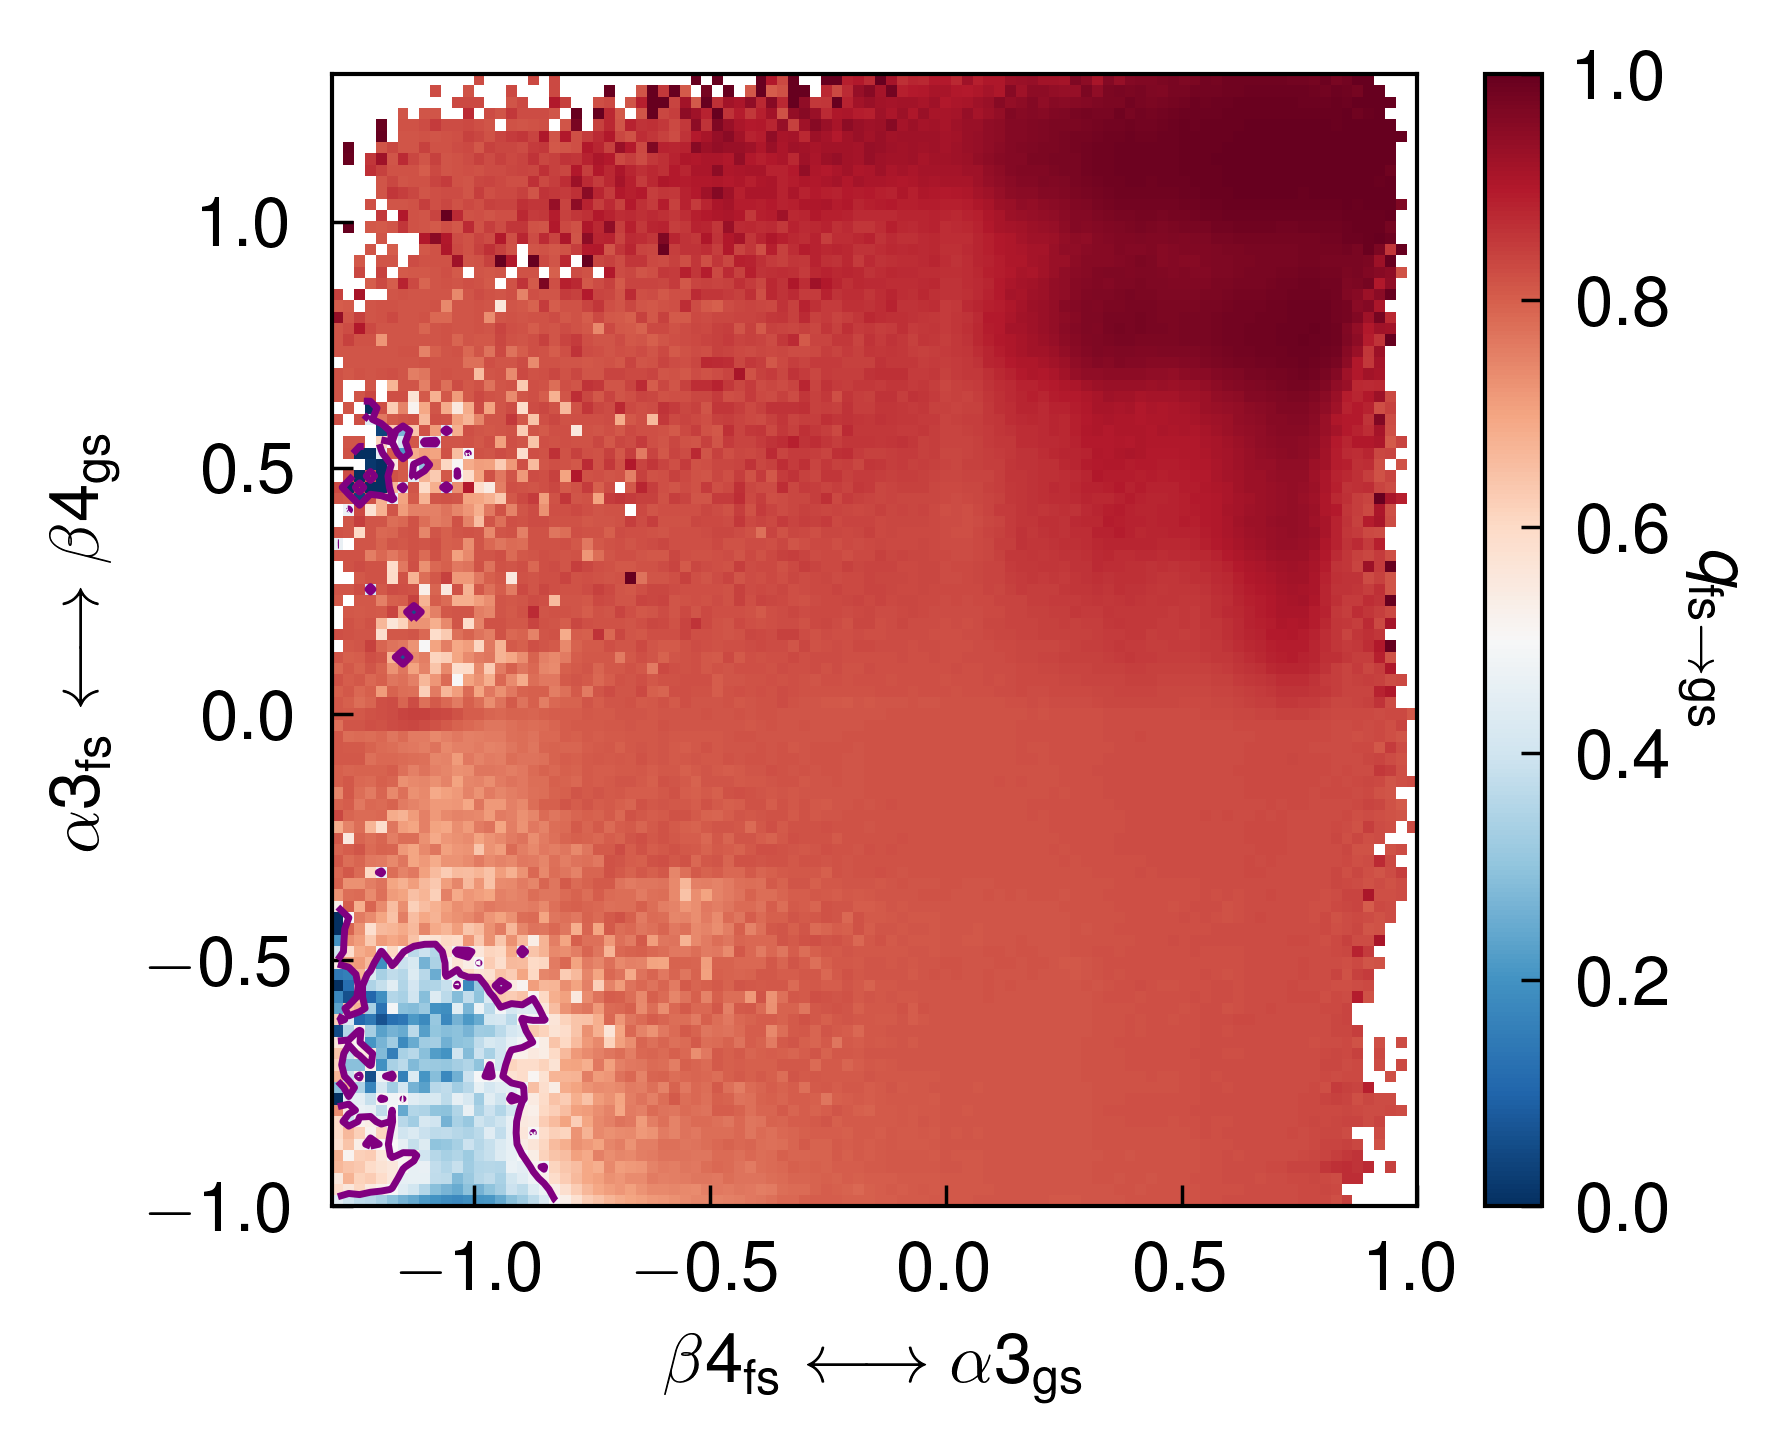

In [95]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
# clines = np.linspace(0, 1, 11)
# colors = ["grey" if i != 5 else "purple" for i in range(10)]

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[:-lag] for t in c_green]
cv2_delay = [t[:-lag] for t in c_blue]
qp_delay = adjust_forward_committor(qp_fs2gs[2], in_d, lag)
hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu_r", vmin=0, vmax=1, rasterized=True)
ax.contour(xc, yc, hist.T, colors="purple", levels=[0.5], linewidths=1)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$q_{\mathrm{fs}\rightarrow\mathrm{gs}}$", rotation=-90, labelpad=10)
plt.savefig("../../dga/figures/t91_qpfs2gs.pdf", bbox_inches='tight')

/scratch/local/jobs/6541398/ipykernel_1526789/4286273669.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(xc, yc, hist.T, colors="purple", levels=[0.5], linewidth=1)


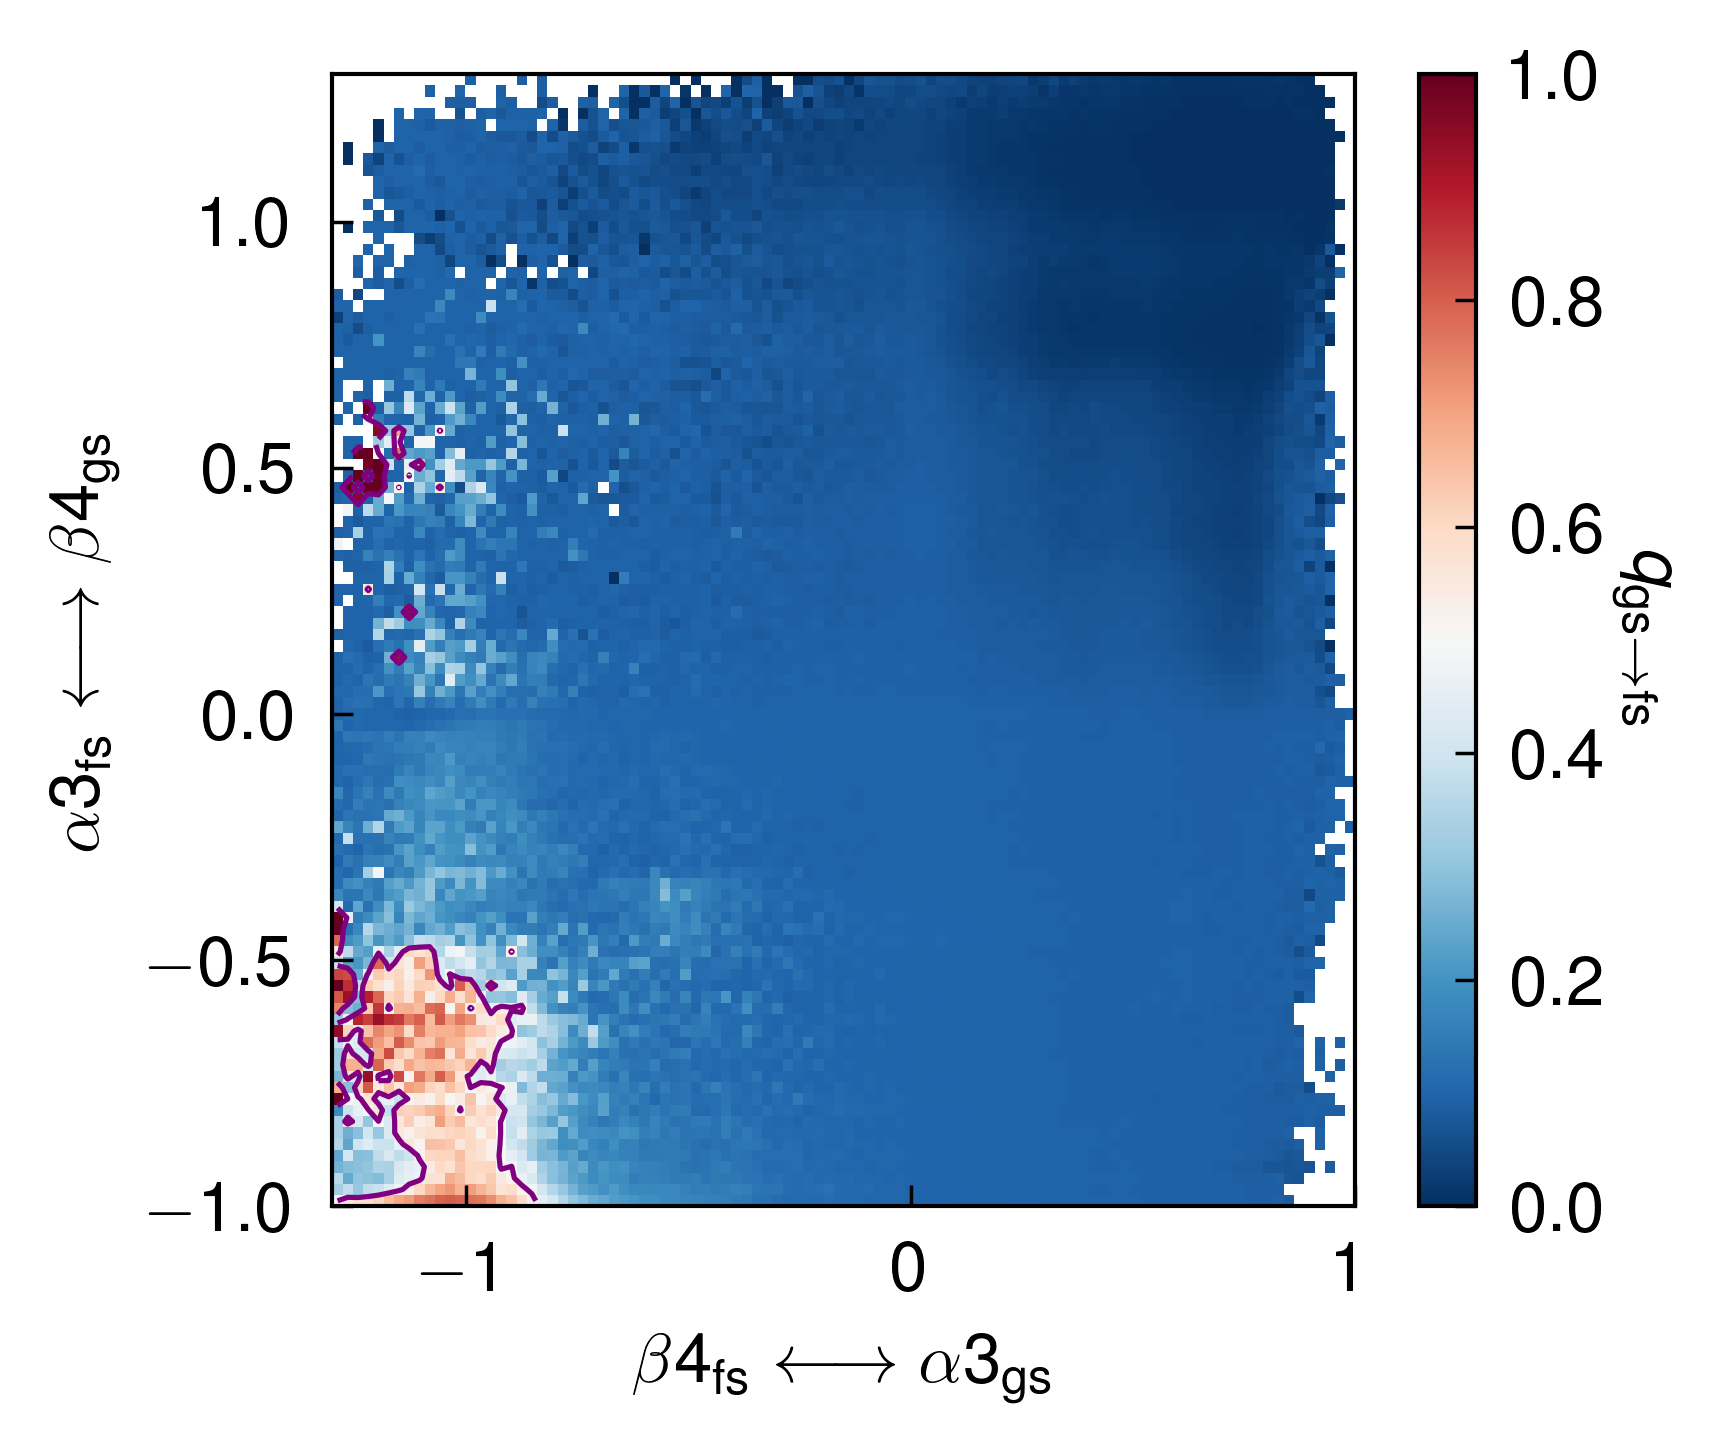

In [96]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.3, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
# clines = np.linspace(0, 1, 11)
# colors = ["grey" if i != 5 else "purple" for i in range(10)]

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[:-lag] for t in c_green]
cv2_delay = [t[:-lag] for t in c_blue]
qp_delay = adjust_forward_committor(qp_gs2fs[2], in_d, lag)
hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="RdBu_r", vmin=0, vmax=1, rasterized=True)
ax.contour(xc, yc, hist.T, colors="purple", levels=[0.5], linewidth=1)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

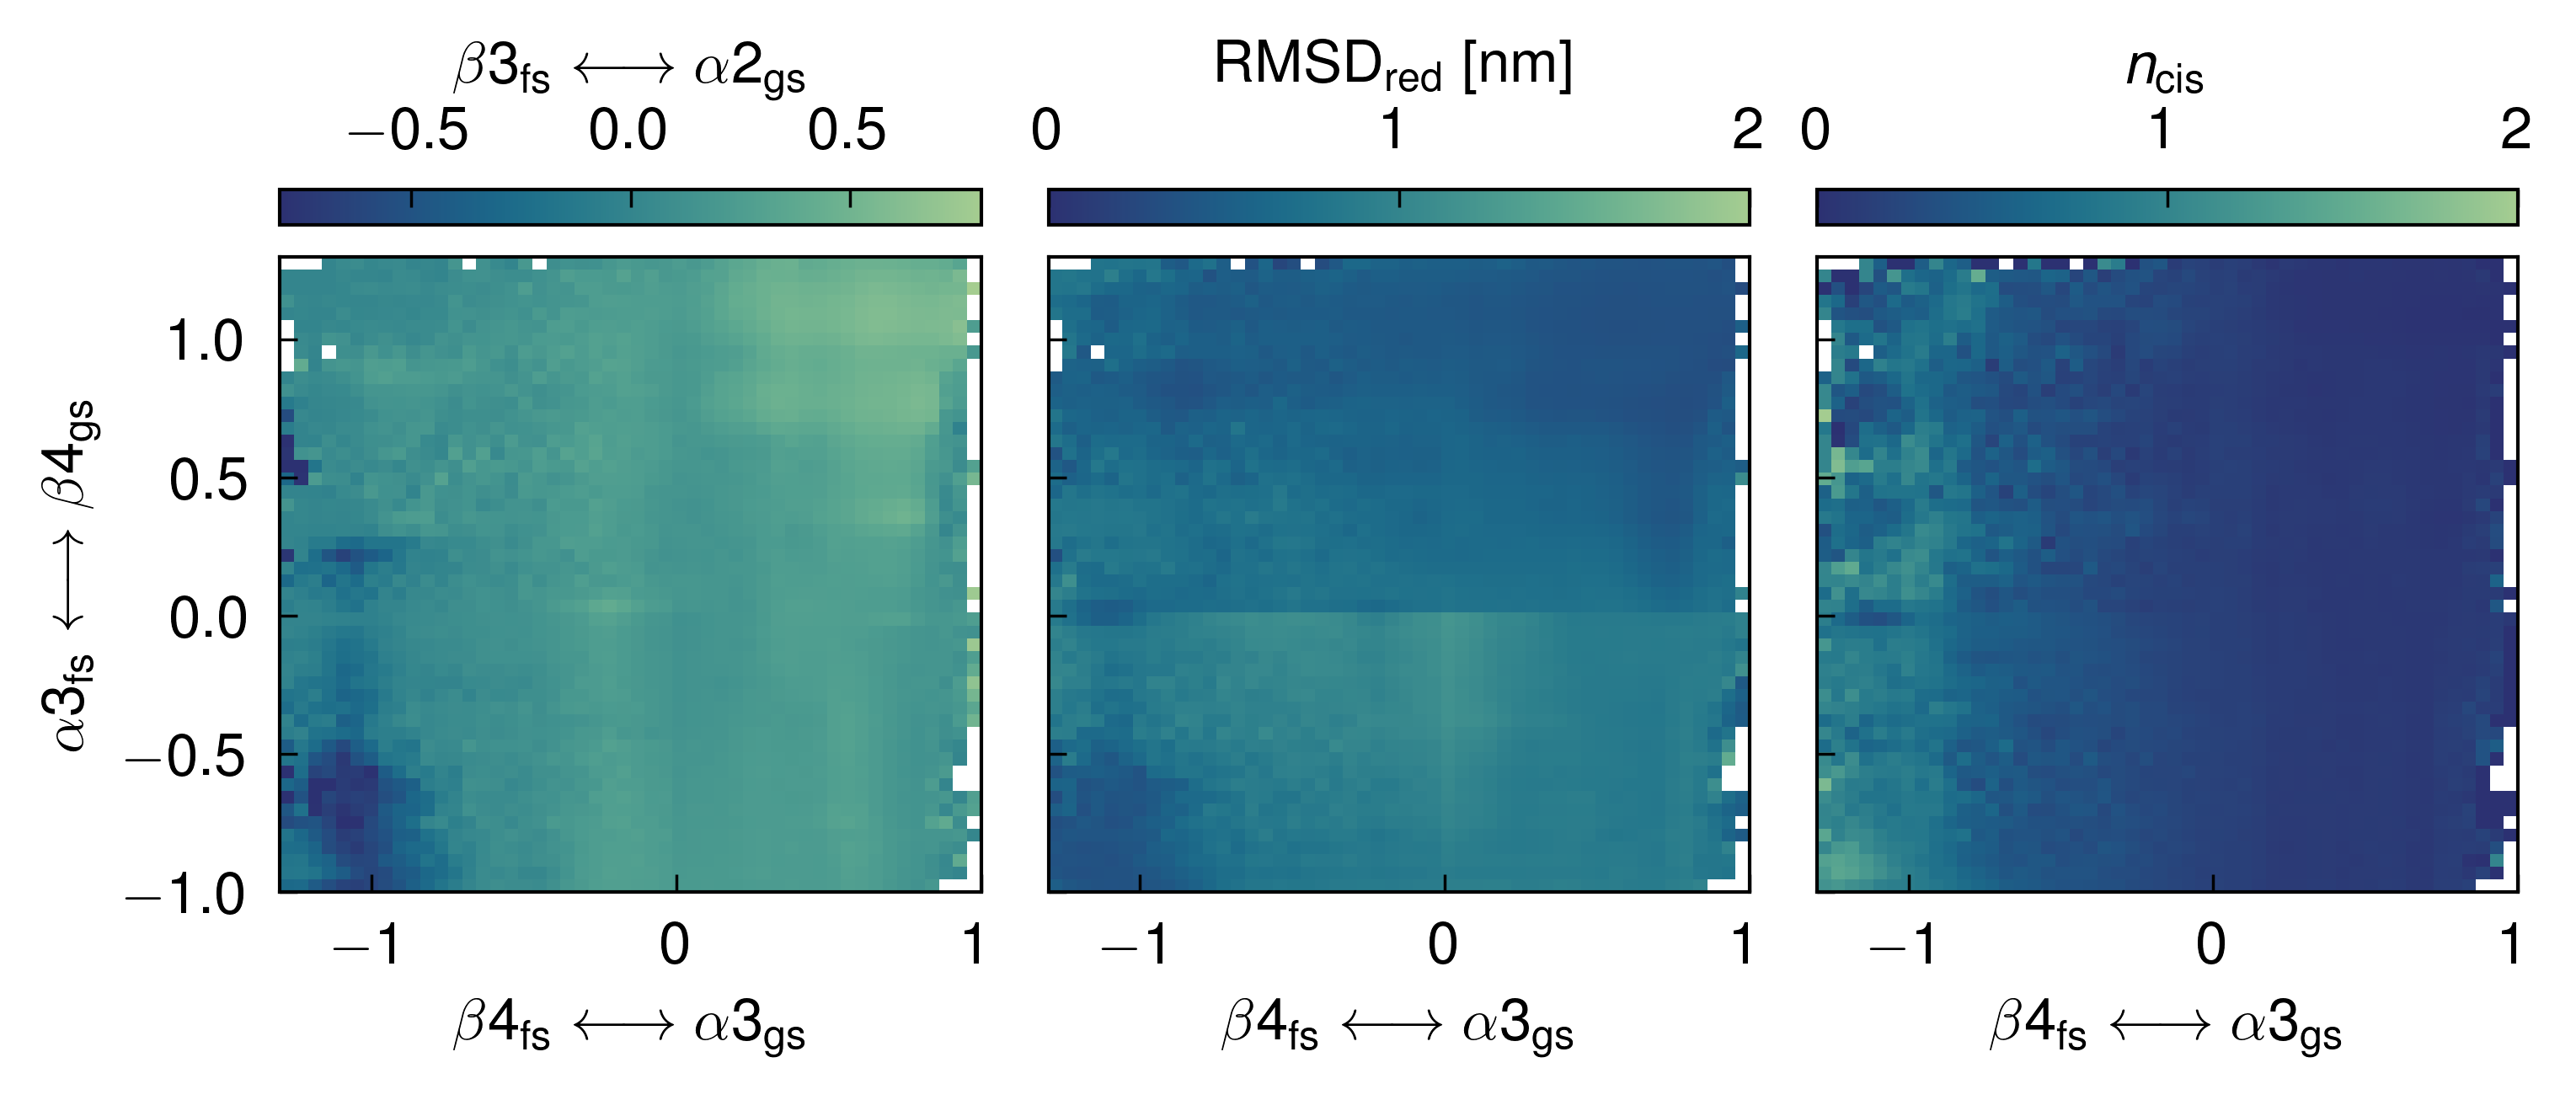

In [97]:
# plot averages of different cvs
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(6, 2.5), dpi=500, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

cvs = [c_orange, r_rmsds, n_cis]
labels = [
    r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    r"RMSD$_{\mathrm{red}}$ [nm]",
    r"$n_{\mathrm{cis}}$",
]
ranges = [(-0.8, 0.8), (0, 2.0), (0, 2)]

for ax, cv, label, (vmin, vmax) in zip(axes, cvs, labels, ranges):
    w_delay = [t[:-lag] for t in weights[-1]]
    cv1_delay = [t[lag:] for t in c_green]
    cv2_delay = [t[lag:] for t in c_blue]
    func_delay = [t[lag:] for t in cv]
    hist = extq.projection.average2d(cv1_delay, cv2_delay, func_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="crest_r", vmin=vmin, vmax=vmax, rasterized=True)
    # ax.contour(xc, yc, hist.T, colors="black", levels=10)
    ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
    ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
    ax.label_outer()
    cb = plt.colorbar(pc, ax=ax, label=label, location="top")
plt.savefig("../../dga/figures/t91_av_ot_rrmsd_ncis.pdf", bbox_inches="tight")

/scratch/local/jobs/6541398/ipykernel_1526789/2302066335.py:14: RuntimeWarning: divide by zero encountered in log
  offset = np.min(-np.log(hist))
/scratch/local/jobs/6541398/ipykernel_1526789/2302066335.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - offset


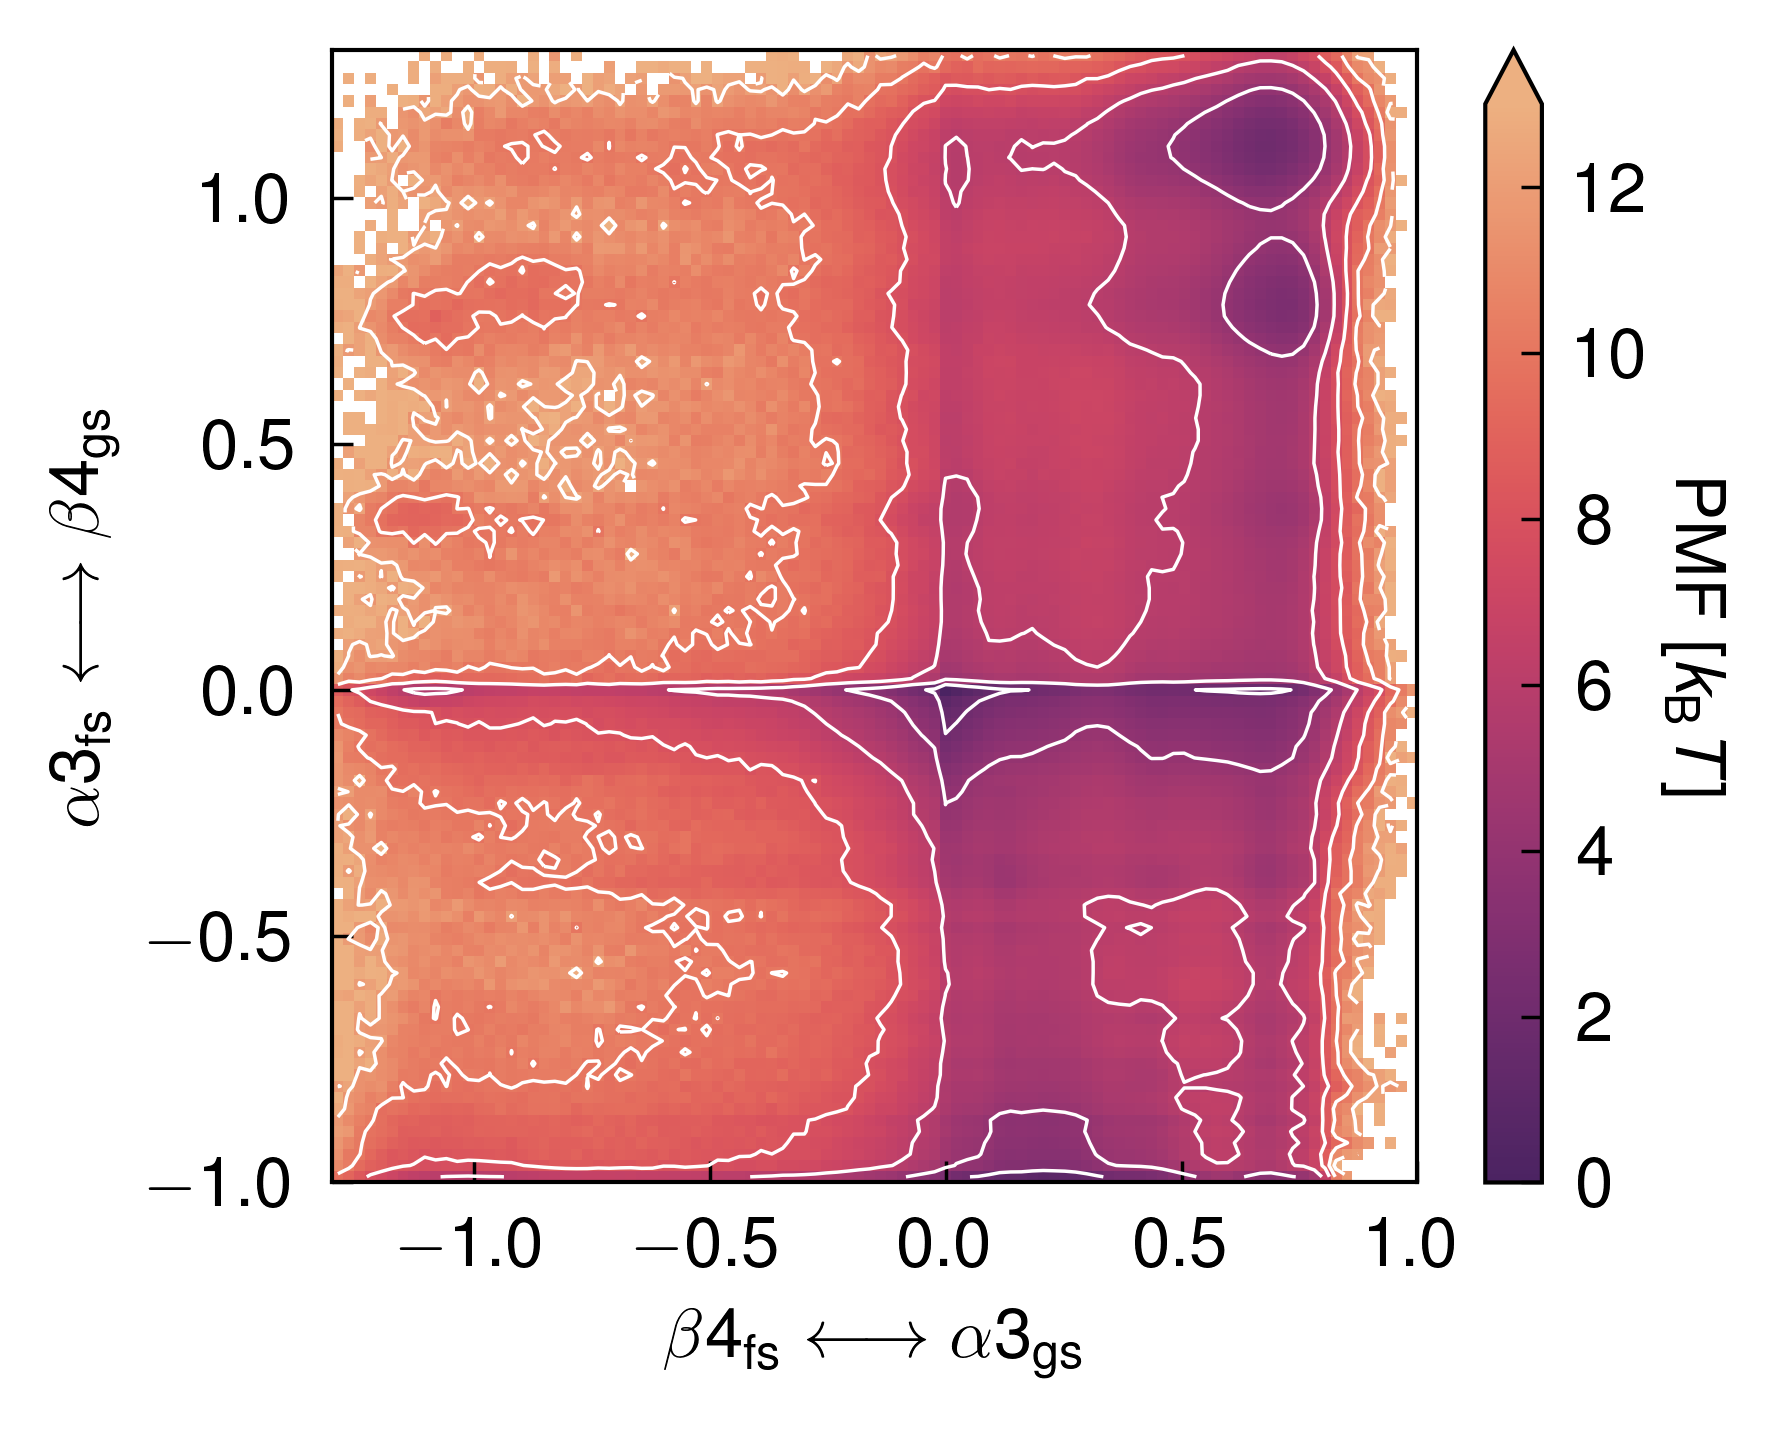

In [98]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
hist = extq.projection.density2d(cv1_delay, cv2_delay, w_delay, xe, ye)
offset = np.min(-np.log(hist))
pmf = -np.log(hist) - offset
pc = ax.pcolormesh(xc, yc, pmf.T, cmap="flare_r", vmax=13, rasterized=True)
ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
# ax.set_title(f"$\\tau$ = {lagtime}")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax, extend="max")
cb.set_label(r"PMF [$k_{\mathrm{B}}T$]", rotation=-90, labelpad=10)
plt.savefig("../../dga/figures/t91_pmf.pdf", bbox_inches="tight")

# TPT rate

## fs -> gs

In [99]:
rate_lags = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000], dtype=int)

In [100]:
in_Ac = np.split((~in_fs).astype(float), traj_inds)
in_B = np.split(in_gs.astype(float), traj_inds)
qm_rc = [(1 - qm) for qm in qm_fs2gs[-1]]

In [101]:
def lag_weights(weights, lag):
    result = []
    for w in weights:
        w[len(w) - lag :] = 0
        result.append(w)
    return result

In [102]:
n_lags = len(rate_lags)
rates_lags = np.zeros((len(lags), 4, n_lags))
rcs = [qp_fs2gs[2], qm_rc, in_B, in_Ac]

for i, (qp, qm) in enumerate(zip(qp_fs2gs, qm_fs2gs)):
    for j, rc in enumerate(rcs):
        for k, lag in enumerate(rate_lags):
            print(f"Computing rates for committor lag {lags[i]}, and RC {j} rate lag {lag}...")
            com = lag_weights(weights[-1], lag)
            rates_lags[i, j, k] = extq.tpt.rate(qp, qm, com, in_d, rc, lag)

Computing rates for committor lag 100, and RC 0 rate lag 10...
Computing rates for committor lag 100, and RC 0 rate lag 20...
Computing rates for committor lag 100, and RC 0 rate lag 50...
Computing rates for committor lag 100, and RC 0 rate lag 100...
Computing rates for committor lag 100, and RC 0 rate lag 200...
Computing rates for committor lag 100, and RC 0 rate lag 500...
Computing rates for committor lag 100, and RC 0 rate lag 1000...
Computing rates for committor lag 100, and RC 0 rate lag 2000...
Computing rates for committor lag 100, and RC 0 rate lag 5000...
Computing rates for committor lag 100, and RC 0 rate lag 10000...
Computing rates for committor lag 100, and RC 1 rate lag 10...
Computing rates for committor lag 100, and RC 1 rate lag 20...
Computing rates for committor lag 100, and RC 1 rate lag 50...
Computing rates for committor lag 100, and RC 1 rate lag 100...
Computing rates for committor lag 100, and RC 1 rate lag 200...
Computing rates for committor lag 100, an

/scratch/local/jobs/6541398/ipykernel_1526789/625111103.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


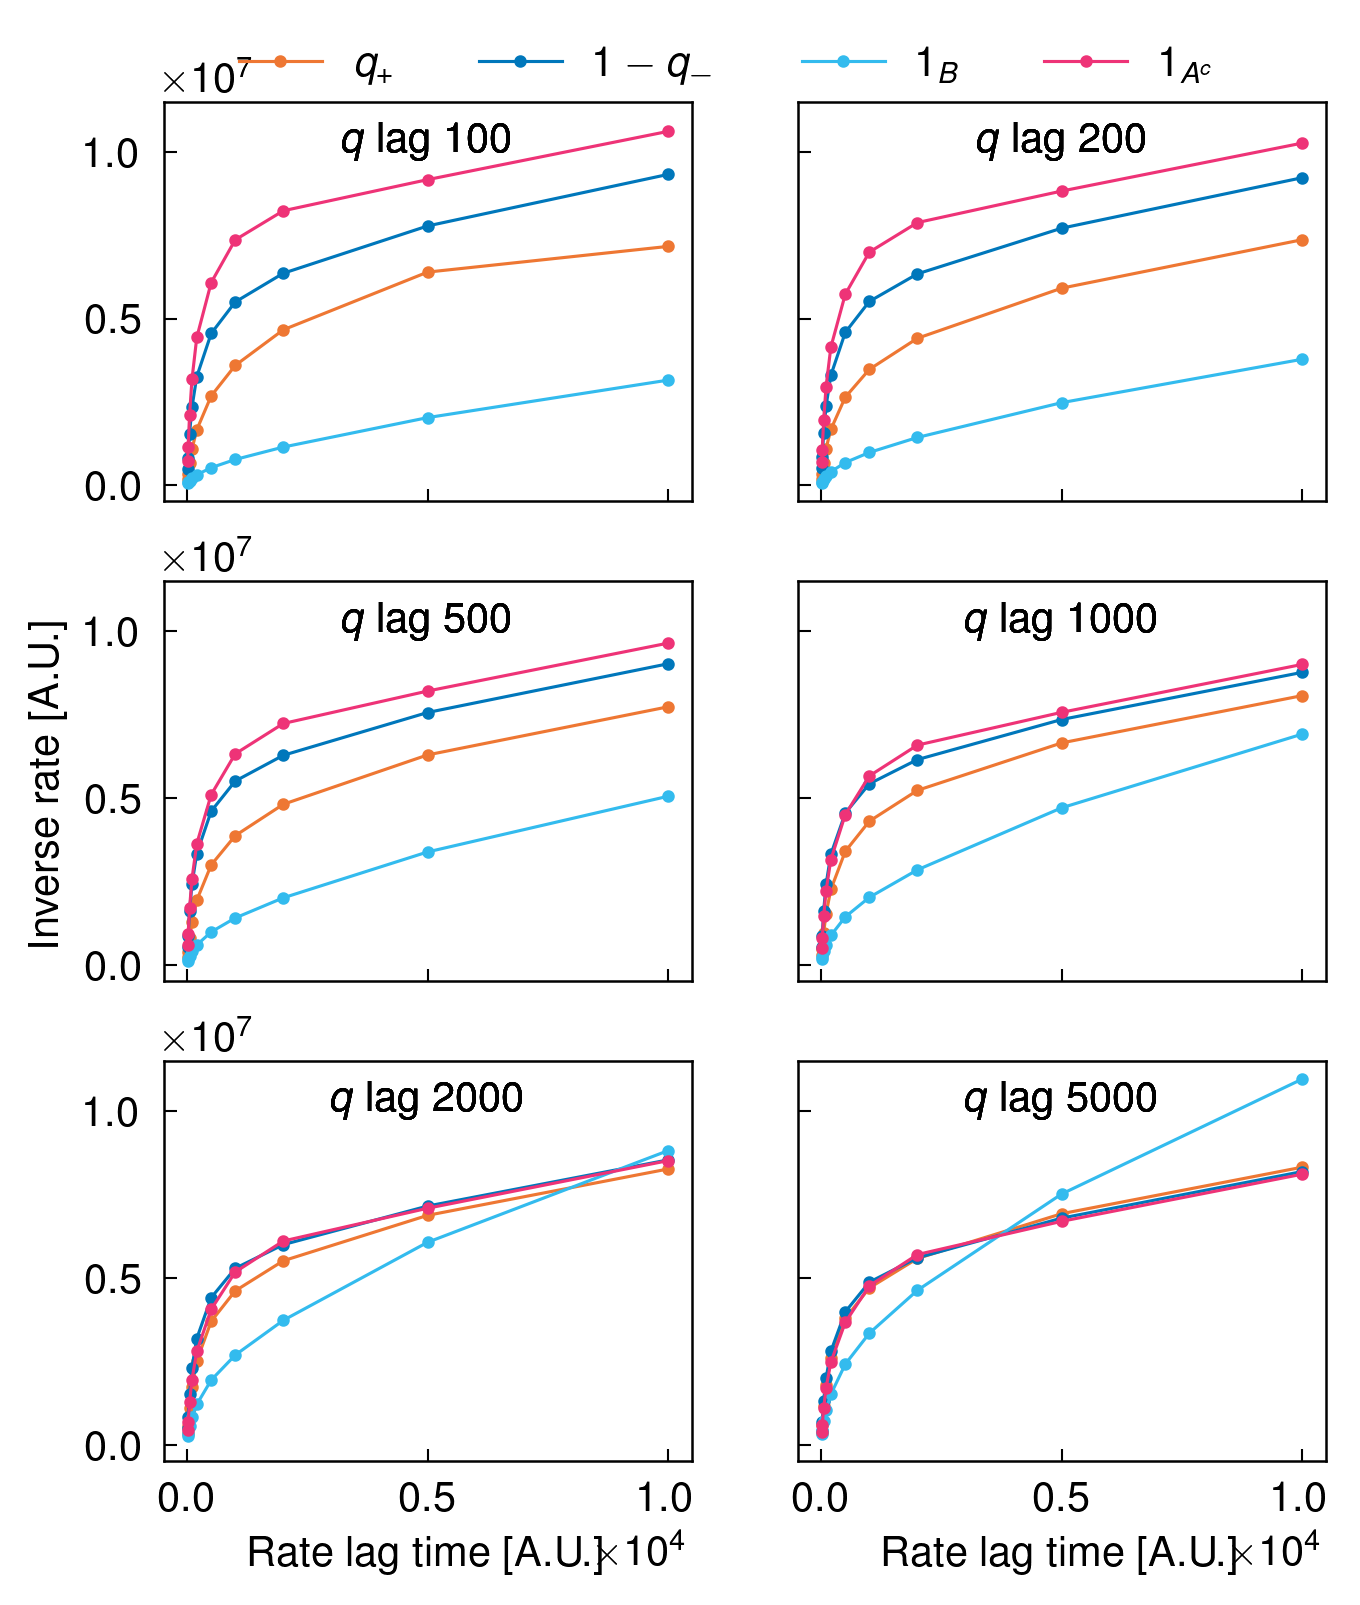

In [103]:
f, axs = plt.subplots(3, 2, figsize=(5, 6), dpi=300, sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    for r in rates_lags[i]:
        ax.plot(rate_lags, 1 / r, "o-")
        pplt.text(0.5, 0.9, f"$q$ lag {lags[i]}", transform=ax.transAxes)
    ax.set_xlabel("Rate lag time [A.U.]")
    ax.label_outer()
axs[1, 0].set_ylabel("Inverse rate [A.U.]")
f.legend(
    ["$q_+$", "$1 - q_-$", r"$\mathbf{1}_B$", r"$\mathbf{1}_{A^c}$"],
    loc="center",
    ncol=4,
    bbox_to_anchor=[0.5, 0.9],
)
plt.tight_layout()

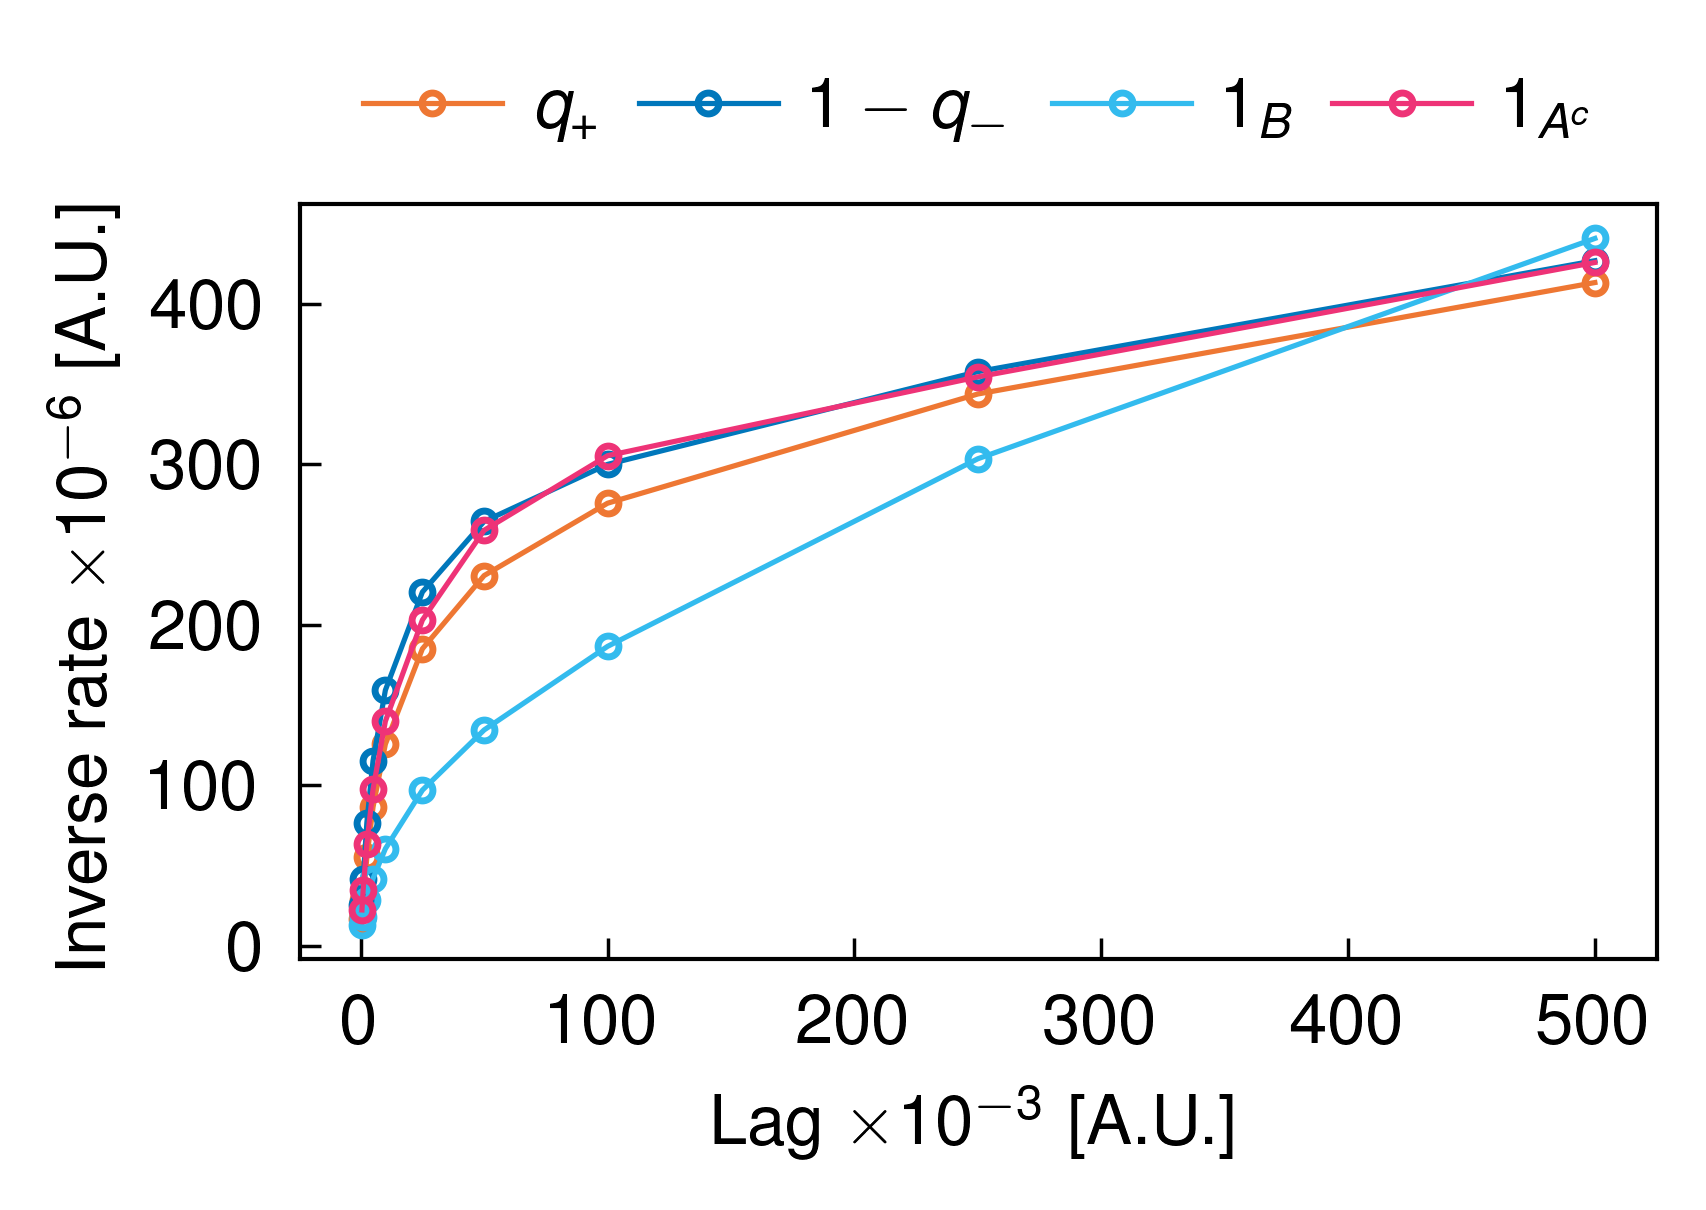

In [104]:
f = plt.figure(figsize=(3.5, 2), dpi=500)
ax = plt.gca()
# best looks like q of 2000 frames
labels = [
    r'$q_+$', 
    r'$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$']

for r, label in zip(rates_lags[4], labels):
    # time steps in 0.1 ns
    ax.plot(rate_lags * 50 * 1e-3, 1 / r * 50 * 1e-6, 'o-', mfc='none', ms=3, label=label)
    
ax.set_xlabel(r"Lag $\times 10^{-3}$ [A.U.]")
ax.set_ylabel(r"Inverse rate $\times 10^{-6}$ [A.U.]")
pplt.legend(outside='top', ncol=4, ax=ax, handletextpad=0.5)

In [105]:
np.save(f"{base_dir}/dga_data/rates_fs2gs.npy", rates_lags)

# gs -> fs

In [106]:
in_Ac = np.split((~in_gs).astype(float), traj_inds)
in_B = np.split(in_fs.astype(float), traj_inds)
qm_rc = [(1 - qm) for qm in qm_gs2fs[-1]]

In [107]:
n_lags = len(rate_lags)
rates_lags = np.zeros((len(lags), 4, n_lags))
rcs = [qp_gs2fs[2], qm_rc, in_B, in_Ac]

for i, (qp, qm) in enumerate(zip(qp_gs2fs, qm_gs2fs)):
    for j, rc in enumerate(rcs):
        for k, lag in enumerate(rate_lags):
            print(f"Computing rates for committor lag {lags[i]}, and RC {j} rate lag {lag}...")
            com = lag_weights(weights[-1], lag)
            rates_lags[i, j, k] = extq.tpt.rate(qp, qm, com, in_d, rc, lag)

Computing rates for committor lag 100, and RC 0 rate lag 10...
Computing rates for committor lag 100, and RC 0 rate lag 20...
Computing rates for committor lag 100, and RC 0 rate lag 50...
Computing rates for committor lag 100, and RC 0 rate lag 100...
Computing rates for committor lag 100, and RC 0 rate lag 200...
Computing rates for committor lag 100, and RC 0 rate lag 500...
Computing rates for committor lag 100, and RC 0 rate lag 1000...
Computing rates for committor lag 100, and RC 0 rate lag 2000...
Computing rates for committor lag 100, and RC 0 rate lag 5000...
Computing rates for committor lag 100, and RC 0 rate lag 10000...
Computing rates for committor lag 100, and RC 1 rate lag 10...
Computing rates for committor lag 100, and RC 1 rate lag 20...
Computing rates for committor lag 100, and RC 1 rate lag 50...
Computing rates for committor lag 100, and RC 1 rate lag 100...
Computing rates for committor lag 100, and RC 1 rate lag 200...
Computing rates for committor lag 100, an

/scratch/local/jobs/6541398/ipykernel_1526789/625111103.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


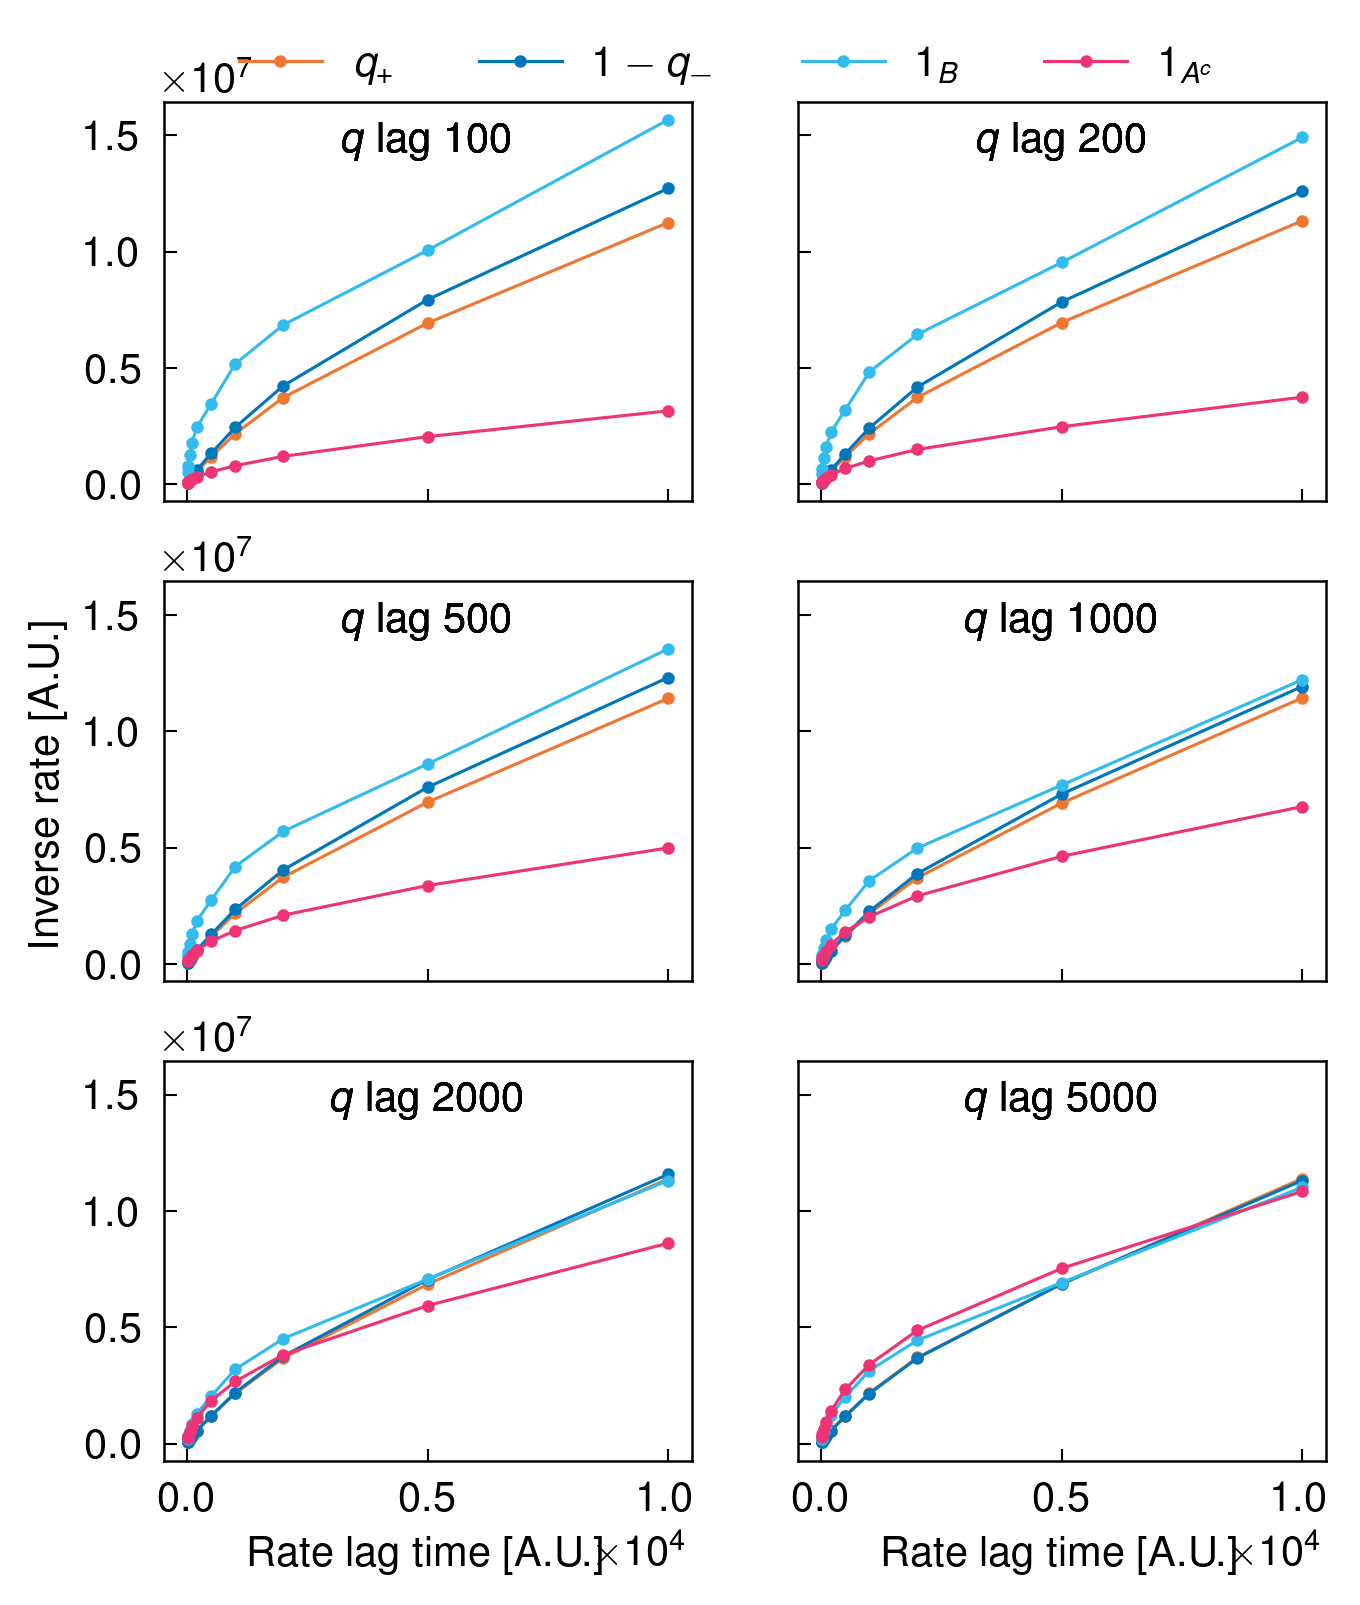

In [108]:
f, axs = plt.subplots(3, 2, figsize=(5, 6), dpi=300, sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    for r in rates_lags[i]:
        ax.plot(rate_lags, 1 / r, "o-")
        pplt.text(0.5, 0.9, f"$q$ lag {lags[i]}", transform=ax.transAxes)
    ax.set_xlabel("Rate lag time [A.U.]")
    ax.label_outer()
axs[1, 0].set_ylabel("Inverse rate [A.U.]")
f.legend(
    ["$q_+$", "$1 - q_-$", r"$\mathbf{1}_B$", r"$\mathbf{1}_{A^c}$"],
    loc="center",
    ncol=4,
    bbox_to_anchor=[0.5, 0.9],
)
plt.tight_layout()

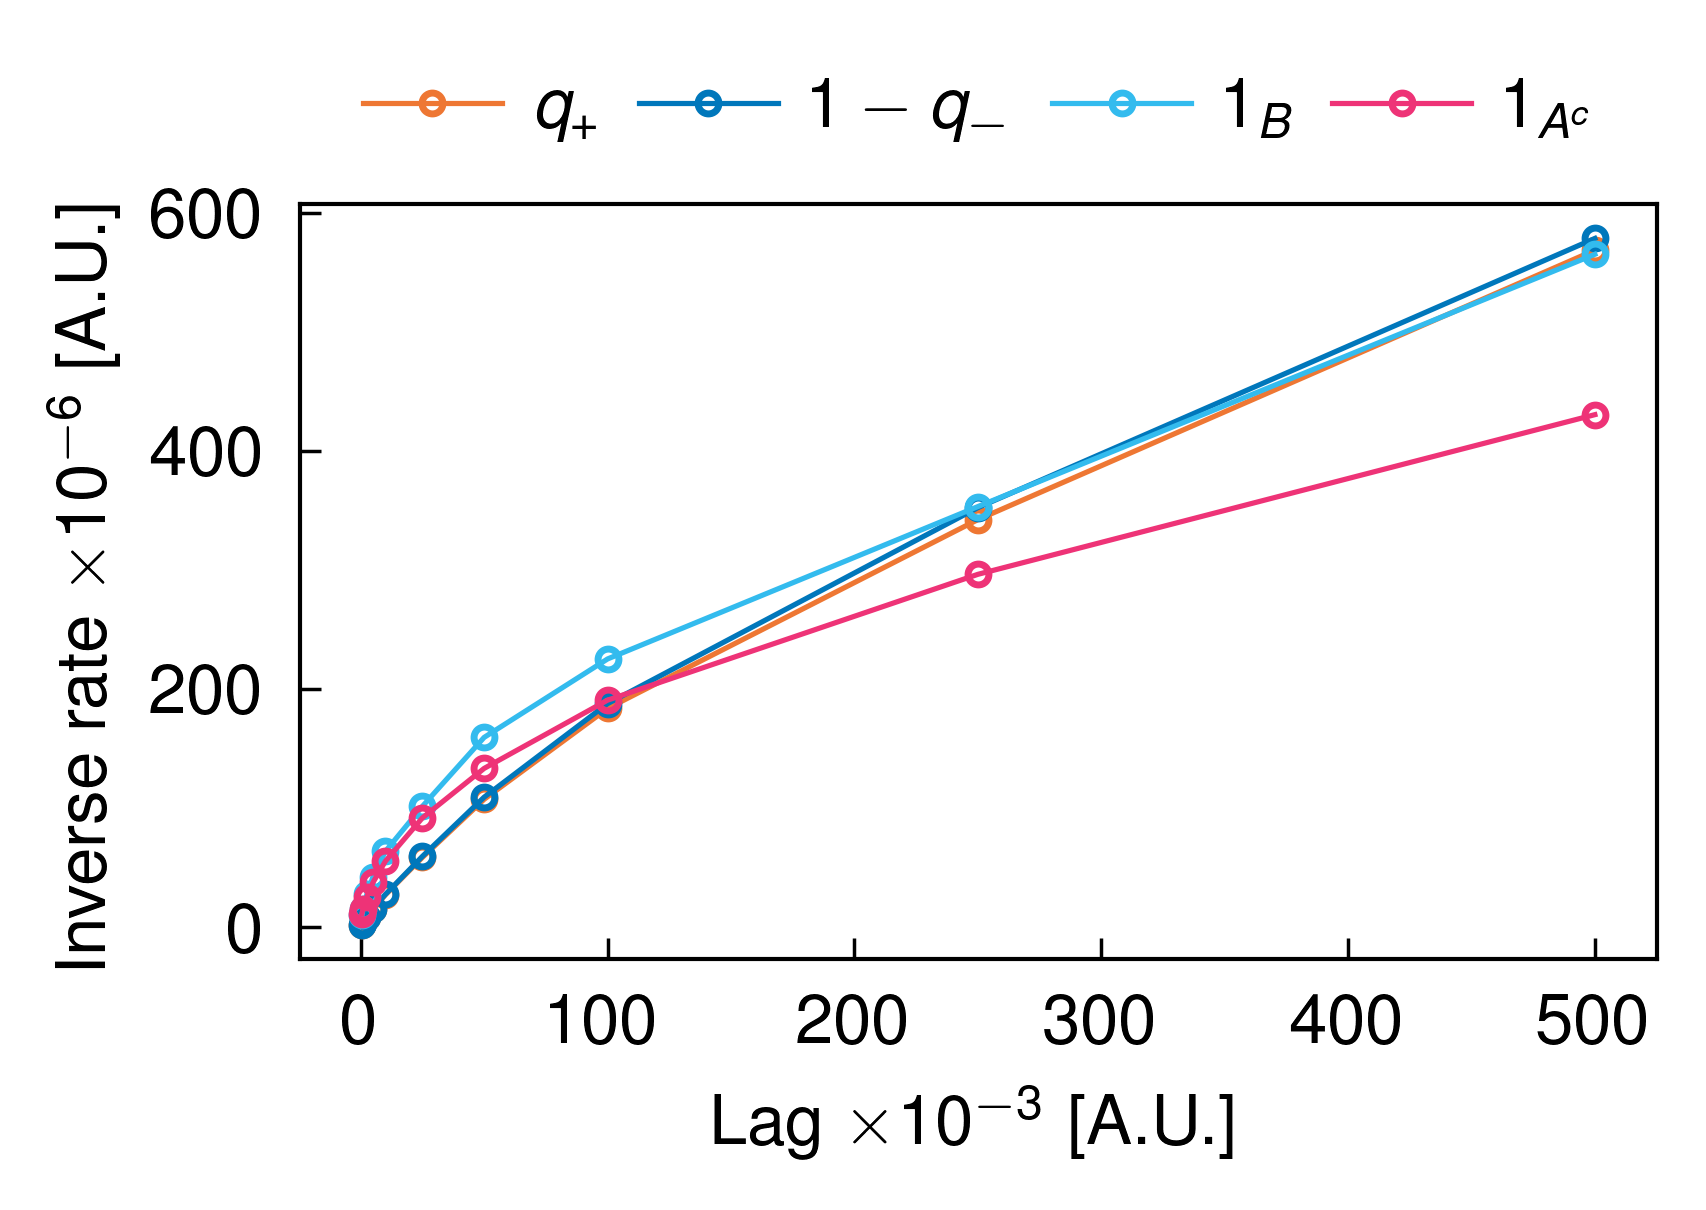

In [109]:
f = plt.figure(figsize=(3.5, 2), dpi=500)
ax = plt.gca()
# best looks like q of 2000 frames
labels = [
    r'$q_+$', 
    r'$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$']

for r, label in zip(rates_lags[4], labels):
    # time steps in 0.1 ns
    ax.plot(rate_lags * 50 * 1e-3, 1 / r * 50 * 1e-6, 'o-', mfc='none', ms=3, label=label)
    
ax.set_xlabel(r"Lag $\times 10^{-3}$ [A.U.]")
ax.set_ylabel(r"Inverse rate $\times 10^{-6}$ [A.U.]")
pplt.legend(outside='top', ncol=4, ax=ax, handletextpad=0.5)

In [110]:
np.save(f"{base_dir}/dga_data/rates_gs2fs.npy", rates_lags)

# MFPT

In [23]:
del raw_feats

In [26]:
# split into lists of arrays
basis_d_arr = basis_arr.copy()
basis_d_arr[in_fs] = 0

/home/scguo/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [27]:
basis_d = []
curr = 0
for t_len in traj_lens:
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

print(len(basis_d), basis_d[0].shape)

640 (39997, 299)


In [28]:
print(lags)

[ 100  200  500 1000 2000 5000]


In [29]:
# guess function: zeros
guess_mfpt = [np.zeros_like(traj) for traj in weights[0]]
in_d_mfpt = np.split(~in_fs, traj_inds)
memlags = [(0, 1), (1, 1), (2, 1), (2, 3), (3, 1), (3, 3), (4, 1), (4, 3), (5, 1), (5, 3)]

mfpts = {}
for lagid, mem in memlags:
    print(f"Computing MFPT for lag {lags[lagid]} and mem {mem}")
    ans = extq.memory.forward_mfpt(basis_d, weights[lagid], in_d_mfpt, guess_mfpt, lags[lagid], mem=mem)
    mfpts[lags[lagid], mem] = ans

Computing MFPT for lag 100 and mem 1
Computing MFPT for lag 200 and mem 1
Computing MFPT for lag 500 and mem 1
Computing MFPT for lag 500 and mem 3
Computing MFPT for lag 1000 and mem 1
Computing MFPT for lag 1000 and mem 3
Computing MFPT for lag 2000 and mem 1
Computing MFPT for lag 2000 and mem 3
Computing MFPT for lag 5000 and mem 1
Computing MFPT for lag 5000 and mem 3


In [24]:
import dill

In [31]:
with open(f"{base_dir}/dga_data/mfpt.pkl", mode="wb+") as f:
    dill.dump(mfpts, f)

In [25]:
# with open(f"{base_dir}/dga_data/mfpt.pkl", mode="rb+") as f:
#     mfpts = dill.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/project/dinner/scguo/kaiB/dga/91/dga_data/mfpt.pkl'

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


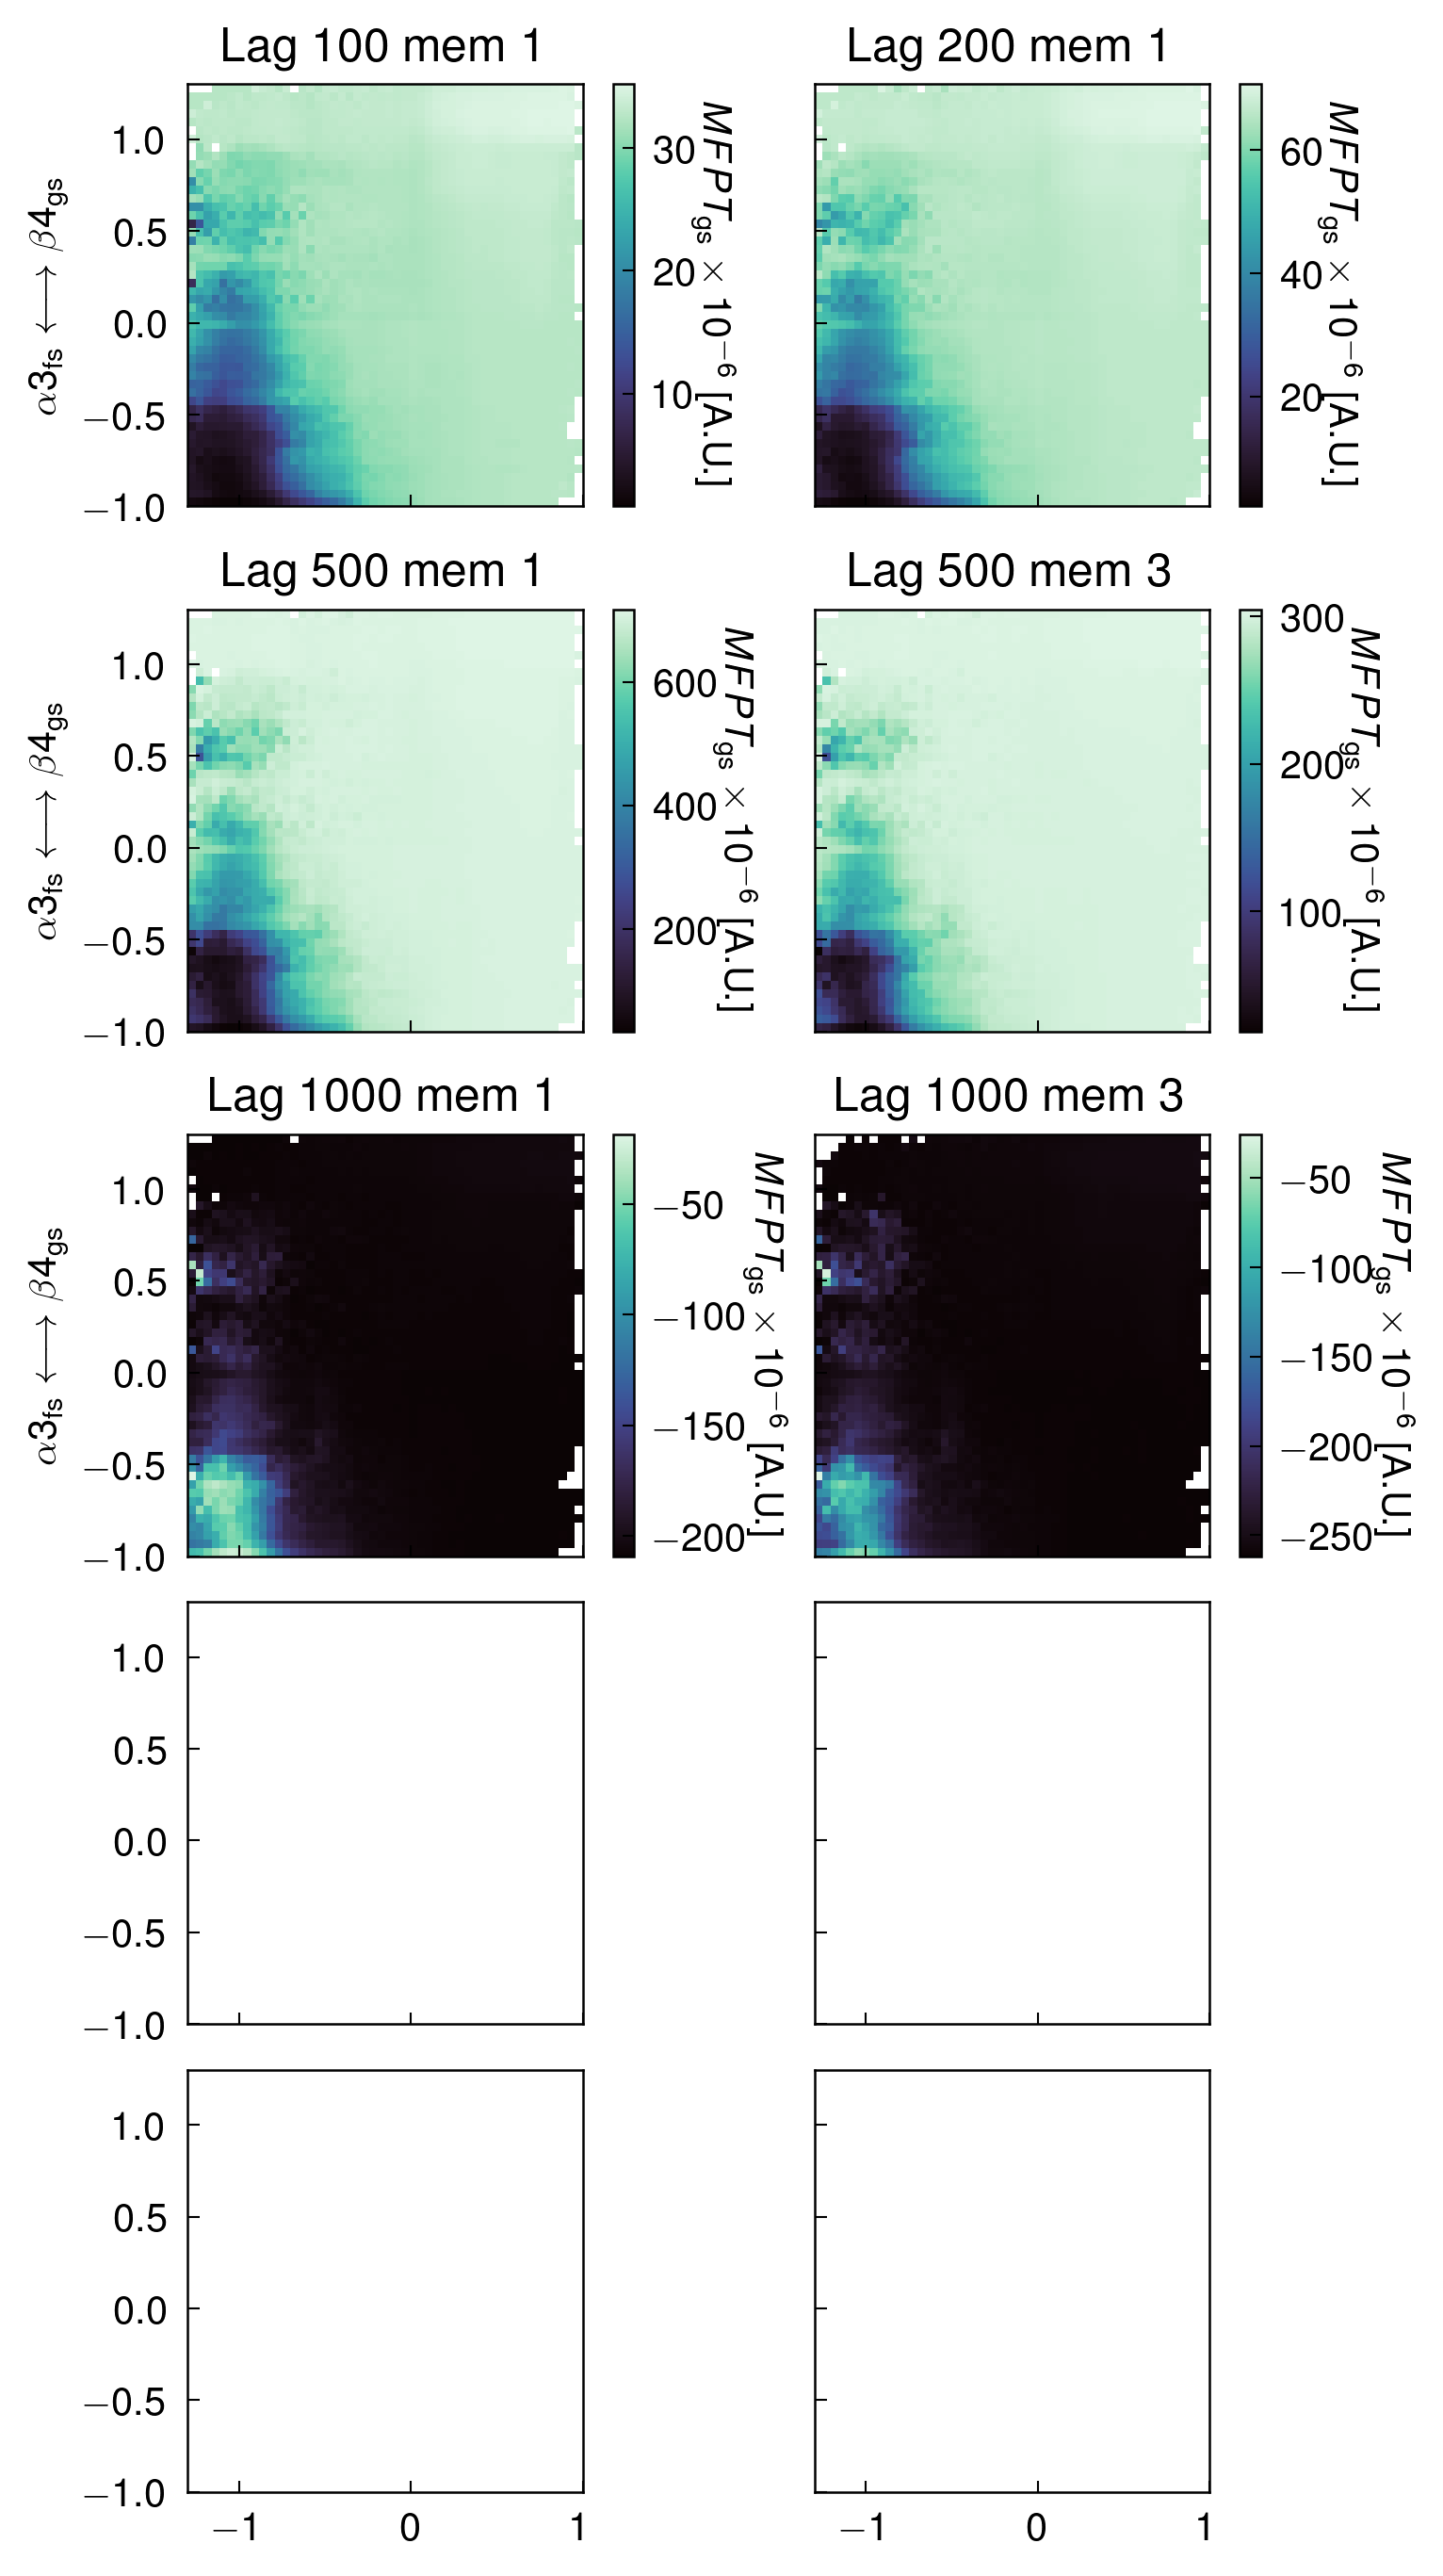

In [35]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(5, 9), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2

for (lag, mem), m, w, ax in zip(mfpts.keys(), mfpts.values(), weights, axes.flat):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[:-lag] for t in c_green]
    cv2_delay = [t[:-lag] for t in c_blue]
    mfpt_delay = adjust_forward_committor(m, in_d_mfpt, lag)
    hist = extq.projection.average2d(cv1_delay, cv2_delay, mfpt_delay, w_delay, xe, ye)
    
    pc = ax.pcolormesh(xc, yc, hist.T * 50 * 1e-6, cmap="mako")
    
    ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
    ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
    ax.set_title(f"Lag {lag} mem {mem}")
    ax.label_outer()
    
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label(r"$MFPT_{\mathrm{gs}}\times 10^{-6}$ [A.U.]", rotation=-90, labelpad=10)